# Generating all data

In [54]:
import itertools
import numpy as np
import scipy
import matplotlib.pyplot as plt
from enum import Enum, auto
from pathlib import Path


def dlqr(F, G, Q, R):
    """Solve the discrete time lqr controller.

    x[k+1] = A x[k] + B u[k]

    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    """
    # ref Bertsekas, p.151

    # first, try to solve the discrete time ricatti equation
    X = np.matrix(scipy.linalg.solve_discrete_are(F, G, Q, R))

    # compute the LQR gain
    K = np.matrix(scipy.linalg.inv(G.T * X * G + R) * (G.T * X * F))

    # eigVals, eigVecs = scipy.linalg.eig(A-B*K)

    return -K


def event(k, a=16, b=0.2):
    return a * (1 - b) ** k


def super_event(x_norm, matrix_norm, k, a, b, sigma=0.01):
    l = sigma * x_norm / matrix_norm + event(k, a, b)

    return l

class ProblemType(Enum):
    Regulator = auto()
    Compensator = auto()

class ControlType(Enum):
    DLQR = auto()
    EventDLQR = auto()

A = 0
B = 0
K = 0

event_simulation_data_file = Path.cwd() / "event_simulation_data_file.npy"

if event_simulation_data_file.exists():
    
    dict_data = np.load(event_simulation_data_file, allow_pickle=True).item()
    
    print(f"dict_data loaded from {event_simulation_data_file}")


    QQ = [np.diag([q, 1]) for q in [1, 5, 1e1, 1e2, 1e3, 1e4, 1e5]]

    for ct, control_type in zip([ControlType.DLQR, ControlType.EventDLQR], ["dlqr", "event_dlqr"]):
        for pt, problem_type in zip([ProblemType.Regulator, ProblemType.Compensator], ["regulator", "compensator"]):
            if ct == ControlType.EventDLQR:
                aa = [10, 16, 20, 25, 30]
                bb = [0.001, 0.01, 0.1, 0.2]
            else:
                aa = [0]
                bb = [0]

            total_tests = len(aa)*len(bb)*len(QQ)

            for k, v in dict_data[ct][pt]['data'].items():
                diverged = v['metrica_comparacao'] == np.inf
                eh_menor_update_rate = ' ***' if k == dict_data[ct][pt]['menor_update_rate'] else '    '
                eh_menor_metrica_comparacao = ' ***' if k == dict_data[ct][pt]['menor_metrica_comparacao'] else '    '
                metrica_comparacao = v['metrica_comparacao']
                update_rate = v['update_rate']
                a = v['a']
                b = v['b']
                Q = v['Q']
                if not diverged:
                    diverged_msg = f" DIVERGED at time {i:.2f} (index {len(k['U'])})" if diverged else ""
                    print(f"[{control_type:>10} - {problem_type:<12} - {k:>4}/{total_tests:<3}] (a={a:<5}, b={b:<5}, q={Q[0,0]:<8.1f} ) Update rate {100*update_rate:>9.3f}%{eh_menor_update_rate} | comparacao: {metrica_comparacao:>10.2f}{eh_menor_metrica_comparacao}{diverged_msg}")
                else:
                    print(f"[{control_type:>10} - {problem_type:<12} - {k:>4}/{total_tests:<3}] (a={a:<5}, b={b:<5}, q={Q[0,0]:<8.1f} ) Update rate {100*update_rate:>9.3f}%     | comparacao: {'DIVERGED!':>10}    {diverged_msg}")

    h = dict_data['timestep']
    A = dict_data['sys_A']
    B = dict_data['sys_B']
    R = dict_data['dlqr_R']
    T = dict_data['time']
    
else:
    h = 0.01

    A = np.array([[1, h],
            [0, 1]])
    B = np.array([[0], [h]])

    # first dd (i=0, N=190)
    #A = np.array([[2.82975412e-15, 1.00000000e+00],
    #              [-9.80269531e-01, 1.97873008e+00]]);
    #B = np.array([[1.84982170e-15], [6.72172757e-03]])

    #best dd (i=3300, N=100) (the least amount of error)
    A = np.array([[ 9.98609061e-01, 1.09025360e+01],
                [-1.13123668e-04, 9.77691957e-01]])
    B = np.array([[0.0086104 ],
                [0.00080799]])

    R = np.eye(1)

    print("A:",A)
    print("B:",B)

    dict_data = {}
    T = np.arange(0, 30, 0.01)

    dict_data['timestep'] = h
    dict_data['sys_A'] = A
    dict_data['sys_B'] = B
    dict_data['dlqr_R'] = R
    dict_data['time'] = T

    QQ = [np.diag([q, 1]) for q in [1, 5, 1e1, 1e2, 1e3, 1e4, 1e5]]

    for ct, control_type in zip([ControlType.DLQR, ControlType.EventDLQR], ["dlqr", "event_dlqr"]):
        dict_data[ct]= {}

        for pt, problem_type in zip([ProblemType.Regulator, ProblemType.Compensator], ["regulator", "compensator"]):
            pode_printar = True
            data_idx = 0

            dict_data[ct][pt]= {}
            dict_data[ct][pt]["data"] = {}
            dict_data[ct][pt]['menor_metrica_comparacao'] = 0
            dict_data[ct][pt]['menor_update_rate'] = 0

            if ct == ControlType.EventDLQR:
                aa = [10, 16, 20, 25, 30]
                bb = [0.001, 0.01, 0.1, 0.2]
            else:
                aa = [0]
                bb = [0]
                
            total_tests = len(QQ)*len(aa)*len(bb)

            for Q in QQ:
                for a in aa:
                    for b in bb:
                        
                        #data[data_idx] = {}
                        #data[data_idx]['a'] = a
                        #data[data_idx]['b'] = b
                        #dict_data[ct][pt]['data'][data_idx]['Q'] = Q

                        data = {}
                        data['a'] = a
                        data['b'] = b
                        data['Q'] = Q

                        K = dlqr(A, B, Q, R)
                        data['K'] = K
                
                        matrix_norm = np.linalg.norm(B @ K, 2)
                
                
                        if pt == ProblemType.Regulator:
                            x = np.array([[1], [-12]])
                        elif pt == ProblemType.Compensator:
                            x = np.array([[0], [0]])
                
                        x_fic = x
                
                        u = np.array([[0]])
                
                        refresh = 0
                        x_norm = np.linalg.norm(x, 2)
                
                        X1 = np.zeros(len(T))
                        X2 = np.zeros(len(T))
                        U = np.zeros(len(T))
                        comparacao = np.zeros(len(T))
                        Xref = np.zeros((2,len(T)))

                        if ct == ControlType.EventDLQR:
                            EV = np.zeros(len(T))
                            EEV = np.zeros(len(T))
                        else:
                            EV = None
                            EEV = None
                
                        erro_estado = 0
                
                        xticks = []
                
                        reference_pos = lambda t : 400*np.sin(2*np.pi*t)
                        #reference_vel = lambda t : 400*np.cos(2*np.pi*t)
                
                        if pt == ProblemType.Regulator:
                            x_ref = np.array([[0], [0]])
                
                        diverged = False
                
                        for idx, i in enumerate(T):
                
                            if pt == ProblemType.Compensator:
                                x_ref = np.array([[reference_pos(i)],[0]])
                
                            E = super_event(x_norm, matrix_norm, i, a, b)
                
                            if pt == ProblemType.Compensator:
                                erro_ref = -(x_ref-x)
                
                            if ct == ControlType.EventDLQR:
                                if erro_estado > E:
                                    if pt == ProblemType.Regulator:
                                        u = K @ x
                                        x_fic = x
                                    elif pt == ProblemType.Compensator:
                                        u = K @ erro_ref
                                        x_fic = erro_ref
                
                                    refresh = refresh + 1
                                    xticks.append(i)
                            else:
                                if pt == ProblemType.Regulator:
                                    u = K @ x
                                    x_fic = x
                                elif pt == ProblemType.Compensator:
                                    u = K @ erro_ref
                                    x_fic = erro_ref
                
                                refresh = refresh + 1
                                xticks.append(i)
                
                            if ct == ControlType.EventDLQR:
                                try:
                                    if pt == ProblemType.Regulator:
                                            erro_estado = np.linalg.norm(x_fic - x, 2)
                                            x_norm = np.linalg.norm(x, 2)
                                    elif pt == ProblemType.Compensator:
                                            erro_estado = np.linalg.norm(x_fic - erro_ref, 2)
                                            x_norm = np.linalg.norm(erro_ref, 2)
                                except:
                                    diverged = True
                                    break
                
                            x = A @ x + B @ u
                
                            X1[idx] = x[0, 0]
                            X2[idx] = x[1, 0]
                            Xref[:,idx] = x_ref[:,0]
                            U[idx] = u[0,0]

                            if ct == ControlType.EventDLQR:
                                EV[idx] = erro_estado
                                EEV[idx] = E
                
                        data['X'] = np.vstack((X1,X2))
                        data['U'] = U
                        data['Xref'] = Xref
                        diverged_msg = f" DIVERGED at time {i:.2f} (index {idx})" if diverged else ""

                        if ct == ControlType.EventDLQR:
                            data['EV'] = EV
                            data['EEV'] = EEV
                            data['event_xticks'] = xticks
                
                        update_rate = refresh / len(T)
                        data['update_rate'] = update_rate
                
                        comparacao = None if diverged else np.square(Xref[0,:] - X1)
                        metrica_comparacao = np.inf if diverged else np.trapz(comparacao, T)
                        data['metrica_comparacao'] = metrica_comparacao

                        if not diverged:
                            if dict_data[ct][pt]['data'].get(dict_data[ct][pt]['menor_update_rate']):
                                if data['update_rate'] < dict_data[ct][pt]['data'][dict_data[ct][pt]['menor_update_rate']]['update_rate']:
                                    dict_data[ct][pt]['menor_update_rate'] = data_idx
                            else:
                                dict_data[ct][pt]['menor_update_rate'] = data_idx
                            
                            if dict_data[ct][pt]['data'].get(dict_data[ct][pt]['menor_metrica_comparacao']):
                                if data['metrica_comparacao'] < dict_data[ct][pt]['data'][dict_data[ct][pt]['menor_metrica_comparacao']]['metrica_comparacao']:
                                    dict_data[ct][pt]['menor_metrica_comparacao'] = data_idx
                            else:
                                dict_data[ct][pt]['menor_metrica_comparacao'] = data_idx
                                
                            print(f"[{control_type:>10} - {problem_type:<12} - {data_idx:>4}/{total_tests:<3}] (a={a:<5}, b={b:<5}, q={Q[0,0]:<8.1f} ) Update rate {100*update_rate:>9.3f}%{' ***' if data_idx == dict_data[ct][pt]['menor_update_rate'] else '    '} | comparacao: {metrica_comparacao:>10.2f}{' ***' if data_idx == dict_data[ct][pt]['menor_metrica_comparacao'] else '    '}{diverged_msg}")
                        else:
                            print(f"[{control_type:>10} - {problem_type:<12} - {data_idx:>4}/{total_tests:<3}] (a={a:<5}, b={b:<5}, q={Q[0,0]:<8.1f} ) Update rate {100*update_rate:>9.3f}%     | comparacao: {'DIVERGED!':>10}    {diverged_msg}")

                        dict_data[ct][pt]['data'][data_idx] = data

                        data_idx += 1




dict_data loaded from /mnt/Data/Git/manopla-system-identification-test/event_simulation_data_file.npy
[      dlqr - regulator    -    0/7  ] (a=0    , b=0    , q=1.0      ) Update rate   100.000% *** | comparacao:   67547.62    
[      dlqr - regulator    -    1/7  ] (a=0    , b=0    , q=5.0      ) Update rate   100.000%     | comparacao:   18528.33    
[      dlqr - regulator    -    2/7  ] (a=0    , b=0    , q=10.0     ) Update rate   100.000%     | comparacao:   10549.41    
[      dlqr - regulator    -    3/7  ] (a=0    , b=0    , q=100.0    ) Update rate   100.000%     | comparacao:    1537.22    
[      dlqr - regulator    -    4/7  ] (a=0    , b=0    , q=1000.0   ) Update rate   100.000%     | comparacao:     188.17    
[      dlqr - regulator    -    5/7  ] (a=0    , b=0    , q=10000.0  ) Update rate   100.000%     | comparacao:      15.82    
[      dlqr - regulator    -    6/7  ] (a=0    , b=0    , q=100000.0 ) Update rate   100.000%     | comparacao:       0.73 ***
[      dl

In [55]:
import control as c

print(A)
print(B)
print(h)
print(R)
controller = dict_data[ct][pt]['data'][0]['K']
print(f"A = {A}")
print(f"B = {B}")
print(f"K = {B*controller}")

reference_pos = lambda t : 400*np.sin(2*np.pi*t)
reference_pos = lambda t : t/1000000

clsys = c.ss(A,B*controller,np.eye(2),np.zeros((2,2)), dt=h)
print(clsys)

output = c.forced_response(clsys, T, reference_pos(T))

plt.plot(output.time, output.outputs[0])
plt.plot(output.time, output.outputs[1])
plt.legend(output.output_labels)

[[ 9.98609061e-01  1.09025360e+01]
 [-1.13123668e-04  9.77691957e-01]]
[[0.0086104 ]
 [0.00080799]]
0.01
[[1.]]
A = [[ 9.98609061e-01  1.09025360e+01]
 [-1.13123668e-04  9.77691957e-01]]
B = [[0.0086104 ]
 [0.00080799]]
K = [[-7.02254892e-03 -1.04384750e+00]
 [-6.58987887e-04 -9.79534451e-02]]
<LinearIOSystem>: sys[100]
Inputs (2): ['u[0]', 'u[1]']
Outputs (2): ['y[0]', 'y[1]']
States (2): ['x[0]', 'x[1]']

A = [[ 9.98609061e-01  1.09025360e+01]
     [-1.13123668e-04  9.77691957e-01]]

B = [[-7.02254892e-03 -1.04384750e+00]
     [-6.58987887e-04 -9.79534451e-02]]

C = [[1. 0.]
     [0. 1.]]

D = [[0. 0.]
     [0. 0.]]

dt = 0.01



ValueError: Parameter ``U``: Wrong shape (rows, columns): (3000,). Expected: (2, 3000).

# Saving All Data

In [56]:
import json
import bz2
from pathlib import Path

event_simulation_data_file = Path.cwd() / "event_simulation_data_file.npy"

if not event_simulation_data_file.exists():
    np.save(event_simulation_data_file, dict_data)
    print(f"dict_data saved to {event_simulation_data_file}")
else:
    print(f"File already exists! (dict_data was not saved to {event_simulation_data_file}!) ")

File already exists! (dict_data was not saved to /mnt/Data/Git/manopla-system-identification-test/event_simulation_data_file.npy!) 


# Print the Best of the Best

In [57]:
table = []
for pt, problem_type in zip([ProblemType.Regulator, ProblemType.Compensator], ["regulator", "compensator"]):
    for ct, control_type in zip([ControlType.DLQR, ControlType.EventDLQR], ["dlqr", "event_dlqr"]):
        if ct == ControlType.EventDLQR:
            criterias = ['menor_metrica_comparacao', 'menor_update_rate']
        else:
            criterias = ['menor_metrica_comparacao']

        for criteria in criterias:
            idx = dict_data[ct][pt][criteria]
            data = dict_data[ct][pt]['data'][idx]
            a = data['a']
            b = data['b']
            q = data['Q'][0,0]
            K = data['K']
            table.append([ct, pt, criteria, data['update_rate']*100, data['metrica_comparacao'], a if ct == ControlType.EventDLQR else '-' , b if ct == ControlType.EventDLQR else '-', q, K])

from tabulate import tabulate
print(tabulate(table, ['Control Type', 'Problem Type', 'Best in Criteria', 'Update Rate [%]', 'Similarity to reference', 'a', 'b', 'q', 'K']))

Control Type           Problem Type             Best in Criteria            Update Rate [%]    Similarity to reference  a    b           q  K
---------------------  -----------------------  ------------------------  -----------------  -------------------------  ---  -----  ------  ---------------------------------
ControlType.DLQR       ProblemType.Regulator    menor_metrica_comparacao         100                          0.726244  -    -      100000  [[  -89.91776447 -1155.41172613]]
ControlType.EventDLQR  ProblemType.Regulator    menor_metrica_comparacao          29.1667                  3607.52      10   0.2      1000  [[ -21.67640067 -644.0524653 ]]
ControlType.EventDLQR  ProblemType.Regulator    menor_update_rate                  0.966667               29666.6       16   0.001       5  [[  -1.90977601 -194.49064542]]
ControlType.DLQR       ProblemType.Compensator  menor_metrica_comparacao         100                        311.2       -    -      100000  [[  -89.91776447 -1155.411

# Print ALL DLQR Controllers

In [58]:
for ct, control_type in zip([ControlType.DLQR], ["dlqr"]):
    for pt, problem_type in zip([ProblemType.Regulator, ProblemType.Compensator], ["regulator", "compensator"]):
        table = []

        for idx, data in dict_data[ct][pt]['data'].items():
            criteria = 'menor_metrica_comparacao'
            a = data['a']
            b = data['b']
            q = data['Q'][0,0]
            K = data['K']
            table.append([idx, ct, pt, criteria, data['metrica_comparacao'], q, K])


        table.sort(key=lambda x: x[3])
        from tabulate import tabulate
        print(tabulate(table, ['idx', 'Control Type', 'Problem Type', 'Best in Criteria', 'Similarity to reference', 'q', 'K']))
        print()

  idx  Control Type      Problem Type           Best in Criteria            Similarity to reference       q  K
-----  ----------------  ---------------------  ------------------------  -------------------------  ------  ---------------------------------
    0  ControlType.DLQR  ProblemType.Regulator  menor_metrica_comparacao               67547.6            1  [[  -0.81558916 -121.23101168]]
    1  ControlType.DLQR  ProblemType.Regulator  menor_metrica_comparacao               18528.3            5  [[  -1.90977601 -194.49064542]]
    2  ControlType.DLQR  ProblemType.Regulator  menor_metrica_comparacao               10549.4           10  [[  -2.70079861 -233.77001218]]
    3  ControlType.DLQR  ProblemType.Regulator  menor_metrica_comparacao                1537.22         100  [[  -8.02918001 -405.15082132]]
    4  ControlType.DLQR  ProblemType.Regulator  menor_metrica_comparacao                 188.168       1000  [[ -21.67640067 -644.0524653 ]]
    5  ControlType.DLQR  ProblemType.Regu

# Generate Latex Table Content with all DLQR Controllers

In [59]:
print("to latex!")

# Senoidal & $ \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$ & $\begin{bmatrix} -0.81558916 & -121.23101168 \end{bmatrix}$ & $1,65181e+06 $ \\ \hline
tables = {}
for ct, control_type in zip([ControlType.DLQR], ["dlqr"]):
    for pt, problem_type in zip([ProblemType.Regulator, ProblemType.Compensator], ["regulator", "compensator"]):
        t=0
        tables[(ct,pt)] =[]
        for idx, data in dict_data[ct][pt]['data'].items():
            criterias = ['menor_metrica_comparacao']
            a = data['a']
            b = data['b']
            q = data['Q'][0,0]
            K = data['K']
            ref_type = "Constante" if pt == ProblemType.Regulator else "Senoidal"
            reference = f"DR{idx}" if pt == ProblemType.Regulator else f"DC{idx}"

            #tables[(ct,pt)] .append([ct, pt, criteria, data['metrica_comparacao'], q, K])
            tables[(ct,pt)].append([f"{reference}", " & ", f"{ref_type:<14}"," & $ \\begin{bmatrix} ", q,  "& 0 \\\\ 0 & 1 \\end{bmatrix} $ & $ \\begin{bmatrix} ", K[0,0], " & ", K[0,1], " \\end{bmatrix} $ & $ ", data['metrica_comparacao'], " $ \\\\ \\hline % ", idx])


        tables[(ct,pt)].sort(key=lambda x: x[8])
        t+=1

print()
print()
from tabulate import tabulate

for t in tables.values():
    print(tabulate(t, ['ref', '-', 'Reference', '-', 'q', '-', 'K[0,0]', '-', 'K[0,1]', '-', 'metric', '-', 'idx']))
    print()

to latex!


ref    -    Reference    -                         q  -                                                     K[0,0]  -       K[0,1]  -                          metric  -                idx
-----  ---  -----------  -------------------  ------  ------------------------------------------------  ----------  ---  ---------  -------------------  ------------  -------------  -----
DR6    &    Constante    & $ \begin{bmatrix}  100000  & 0 \\ 0 & 1 \end{bmatrix} $ & $ \begin{bmatrix}  -89.9178    &    -1155.41   \end{bmatrix} $ & $      0.726244  $ \\ \hline %      6
DR5    &    Constante    & $ \begin{bmatrix}   10000  & 0 \\ 0 & 1 \end{bmatrix} $ & $ \begin{bmatrix}  -50.5014    &     -924      \end{bmatrix} $ & $     15.8171    $ \\ \hline %      5
DR4    &    Constante    & $ \begin{bmatrix}    1000  & 0 \\ 0 & 1 \end{bmatrix} $ & $ \begin{bmatrix}  -21.6764    &     -644.052  \end{bmatrix} $ & $    188.168     $ \\ \hline %      4
DR3    &    Constante    & $ \begin{bmatrix}    

# Generate Latex Table Content with the best Event-DLQR Controllers + parameters

In [60]:
print("to latex!")

# Senoidal & $ \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}$ & $\begin{bmatrix} -0.81558916 & -121.23101168 \end{bmatrix}$ & $1,65181e+06 $ \\ \hline
tables = {}
for ct, control_type in zip([ControlType.EventDLQR], ["event-dlqr"]):
    for pt, problem_type in zip([ProblemType.Regulator, ProblemType.Compensator], ["regulator", "compensator"]):
        t=0
        tables[(ct,pt)] =[]
        for idx, data in dict_data[ct][pt]['data'].items():
            if idx in [dict_data[ct][pt]['menor_metrica_comparacao'], dict_data[ct][pt]['menor_update_rate']]:
                a = data['a']
                b = data['b']
                q = data['Q'][0,0]
                K = data['K']
                ref_type = "Constante" if pt == ProblemType.Regulator else "Senoidal"
                reference = f"EDR{idx}" if pt == ProblemType.Regulator else f"EDC{idx}"

                #tables[(ct,pt)] .append([ct, pt, criteria, data['metrica_comparacao'], q, K])
                tables[(ct,pt)].append([f"{reference}", " & ", f"{ref_type:<14}"," & $ \\begin{bmatrix} ", q,  "& 0 \\\\ 0 & 1 \\end{bmatrix} $ & ",a, " & ", b, " & $ \\begin{bmatrix} ", K[0,0], " & ", K[0,1], " \\end{bmatrix} $ & $ ", data['metrica_comparacao'], " $ & $ ", data['update_rate']*100 , " $ \\\\ \\hline % ", idx])


        #tables[(ct,pt)].sort(key=lambda x: x[8])
        t+=1

print()
print()
from tabulate import tabulate

for t in tables.values():
    print(tabulate(t, ['% ref', '-', 'Reference', '-', 'q', '-', 'a', '-', 'b', '-', 'K[0,0]', '-', 'K[0,1]', '-', 'metrica_comparacao', '-', 'update_rate', '-', 'idx']))
    print()

to latex!


% ref    -    Reference    -                       q  -                                 a  -        b  -                       K[0,0]  -      K[0,1]  -                      metrica_comparacao  -        update_rate  -                idx
-------  ---  -----------  -------------------  ----  ------------------------------  ---  ---  -----  -------------------  ---------  ---  --------  -------------------  --------------------  -----  -------------  -------------  -----
EDR24    &    Constante    & $ \begin{bmatrix}     5  & 0 \\ 0 & 1 \end{bmatrix} $ &   16  &    0.001  & $ \begin{bmatrix}   -1.90978  &    -194.491  \end{bmatrix} $ & $              29666.6   $ & $       0.966667  $ \\ \hline %     24
EDR83    &    Constante    & $ \begin{bmatrix}  1000  & 0 \\ 0 & 1 \end{bmatrix} $ &   10  &    0.2    & $ \begin{bmatrix}  -21.6764   &    -644.052  \end{bmatrix} $ & $               3607.52  $ & $      29.1667    $ \\ \hline %     83

% ref    -    Reference    -               

# Show Visual Comparison Between the Best and Worst DLQR Controllers

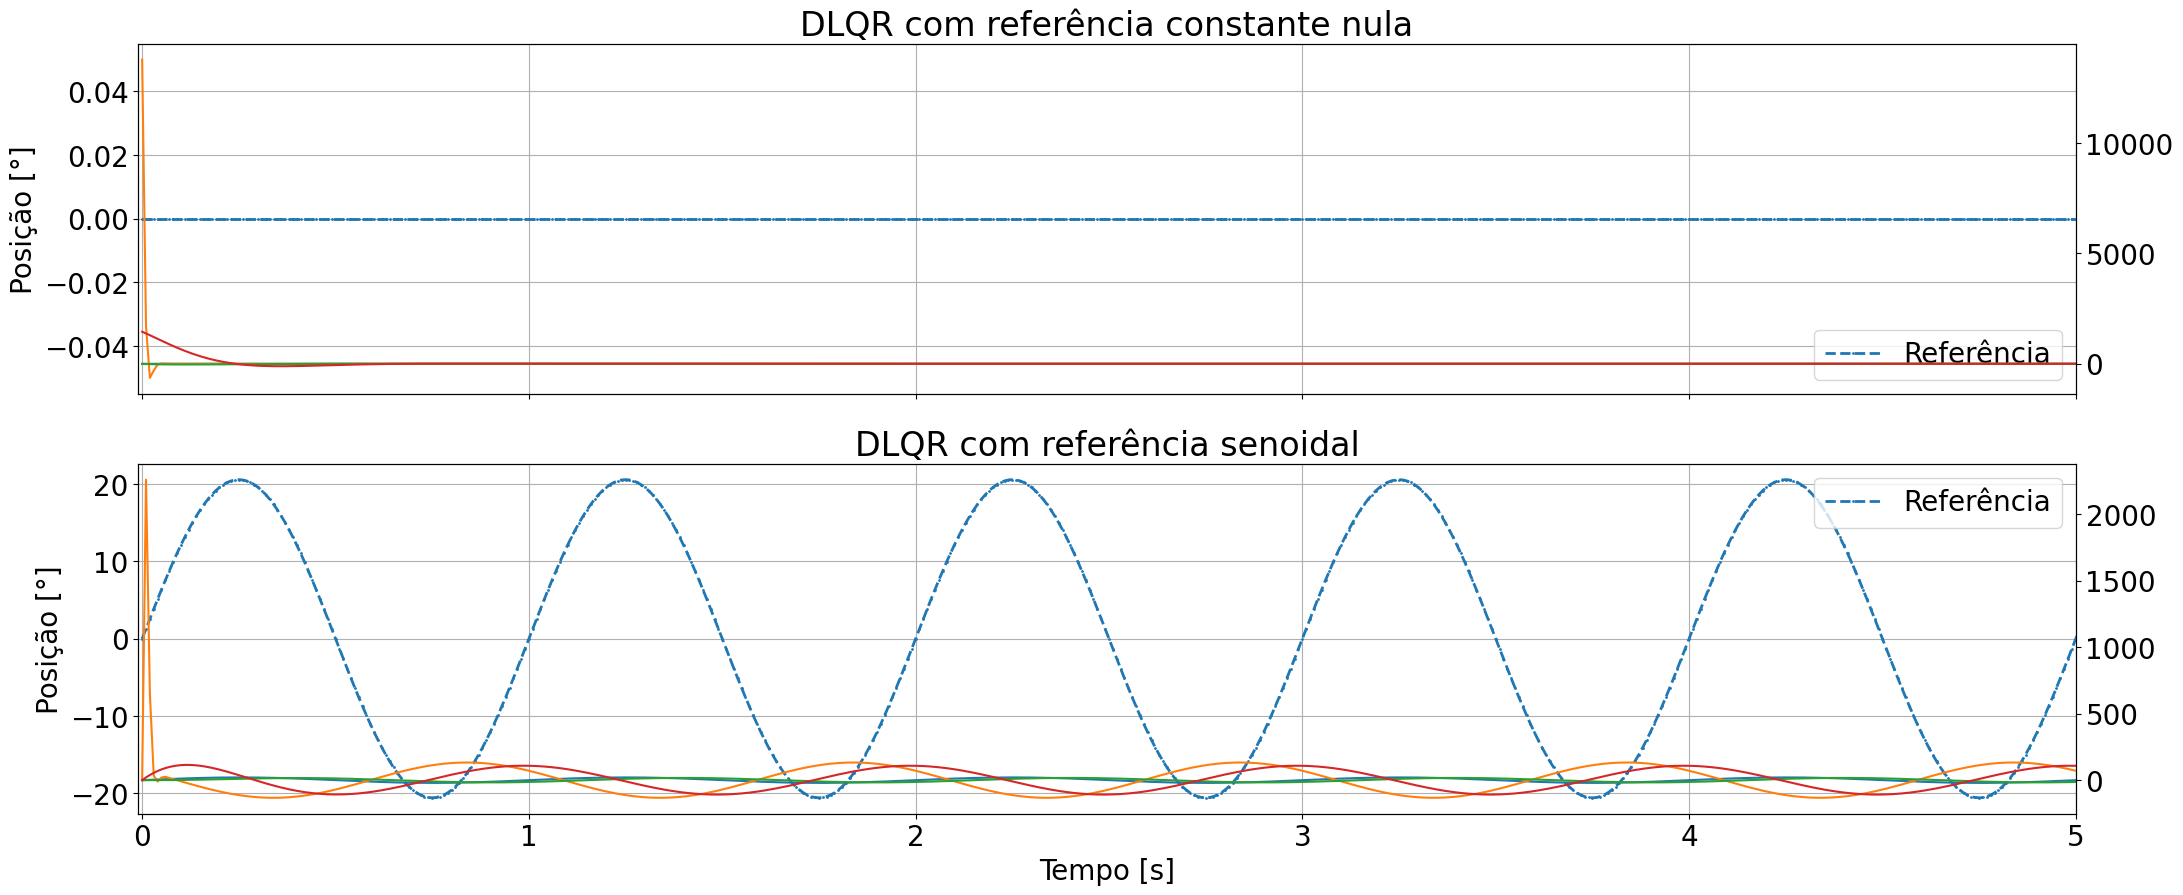

In [61]:
xlim=(-0.01,5)

plt.rcParams.update({'font.size': 20})
import matplotlib as mpl
#plt.rcParams.update(mpl.rcParamsDefault)
T = dict_data['time']
fig, axs= plt.subplots(2, 1, figsize=(25,10), sharex=True)
for ct, control_type in zip([ControlType.DLQR], ["dlqr"]):
    i=0
    for pt, problem_type in zip([ProblemType.Regulator, ProblemType.Compensator], ["regulator", "compensator"]):
        data = dict_data[ct][pt]['data']
        leg = []
        axs[i].plot(T, data[0]['Xref'][0]*360/(3.5*2000), 'o--', markersize=1, linewidth=2)
        leg.append('Referência')

        ax2 = axs[i].twinx()
        for idx in [6,0]:
            reference = f"DR{idx}" if pt == ProblemType.Regulator else f"DC{idx}"
            ax2.plot(T, data[idx]['X'][0]*360/(3.5*2000))
            ax2.plot(T, data[idx]['U'])
            leg.append(f"{reference} (métrica={round(data[idx]['metrica_comparacao'],3)})")

        axs[i].set_xlim(xlim)
        axs[i].grid()
        axs[i].set_ylabel("Posição [°]")
        if pt == ProblemType.Regulator:
            axs[i].legend(leg, loc='lower right')
            axs[i].set_title("DLQR com referência constante nula")
        else:
            axs[i].set_xlabel("Tempo [s]")
            axs[i].legend(leg, loc='upper right')
            axs[i].set_title("DLQR com referência senoidal")
        i+=1


plt.show()


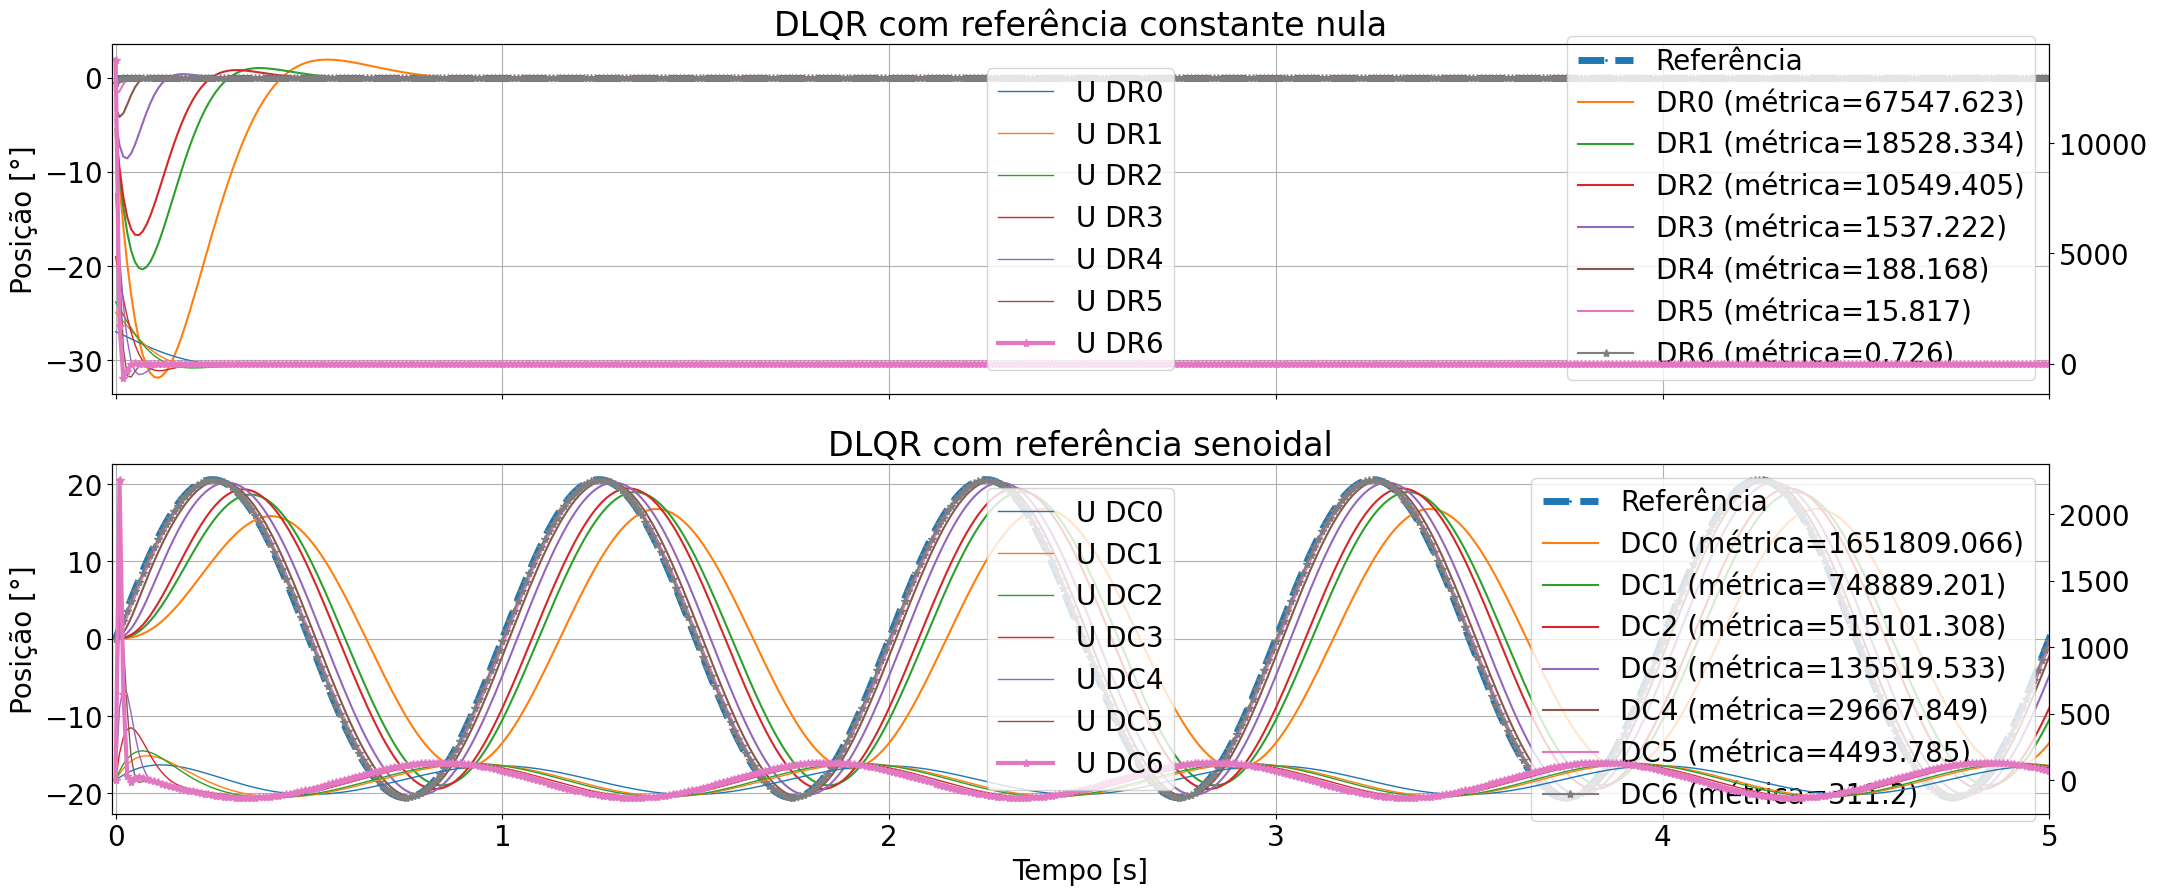

In [66]:
xlim=(-0.01,5)

plt.rcParams.update({'font.size': 20})
import matplotlib as mpl
#plt.rcParams.update(mpl.rcParamsDefault)
T = dict_data['time']
#xlim = [-.01, .2]
fig, axs= plt.subplots(2, 1, figsize=(25,10), sharex=True)
for ct, control_type in zip([ControlType.DLQR], ["dlqr"]):
    i=0
    for pt, problem_type in zip([ProblemType.Regulator, ProblemType.Compensator], ["regulator", "compensator"]):
        data = dict_data[ct][pt]['data']
        leg = []
        leg2 = []
        axs[i].plot(T, data[0]['Xref'][0]*360/(3.5*2000), 'o--', markersize=1, linewidth=5)
        leg.append('Referência')

        ax2 = axs[i].twinx()
        for idx in range(7):
            reference = f"DR{idx}" if pt == ProblemType.Regulator else f"DC{idx}"
            axs[i].plot(T, data[idx]['X'][0]*360/(3.5*2000), '-*' if idx == 6 else '-')
            leg.append(f"{reference} (métrica={round(data[idx]['metrica_comparacao'],3)})")
            ax2.plot(T, data[idx]['U'], '-*' if idx == 6 else '-', linewidth=3 if idx==6 else 1)
            leg2.append(f"U {reference}")

        axs[i].set_xlim(xlim)
        axs[i].grid()
        axs[i].set_ylabel("Posição [°]")
        if pt == ProblemType.Regulator:
            axs[i].legend(leg, loc='lower right')
            axs[i].set_title("DLQR com referência constante nula")
        else:
            axs[i].set_xlabel("Tempo [s]")
            axs[i].legend(leg, loc='upper right')
            axs[i].set_title("DLQR com referência senoidal")
        ax2.legend(leg2, loc='center')
        i+=1

        #plt.xlim(xlim)


plt.show()

# 3D-Plot ALL Event-DLQR Metric Results

ploting graph_top_q
2 3 continuing...
3 3 continuing...
dict_keys(['1_update_rate', '5_update_rate', '10_update_rate', '100_update_rate', '1_metrica_comparacao', '5_metrica_comparacao', '10_metrica_comparacao', '100_metrica_comparacao', '1000_update_rate', '10000_update_rate', '100000_update_rate', '1000_metrica_comparacao', '10000_metrica_comparacao', '100000_metrica_comparacao'])
ploting graph_top_a
2 2 continuing...
3 2 continuing...
dict_keys(['10_update_rate', '16_update_rate', '20_update_rate', '10_metrica_comparacao', '16_metrica_comparacao', '20_metrica_comparacao', '25_update_rate', '30_update_rate', '25_metrica_comparacao', '30_metrica_comparacao'])
ploting graph_top_b
dict_keys(['0.001_update_rate', '0.01_update_rate', '0.001_metrica_comparacao', '0.01_metrica_comparacao', '0.1_update_rate', '0.2_update_rate', '0.1_metrica_comparacao', '0.2_metrica_comparacao'])
10    0.001 1     91874.37  
16    0.001 1     97236.09  
20    0.001 1     101003.36 
25    0.001 1     111059.17

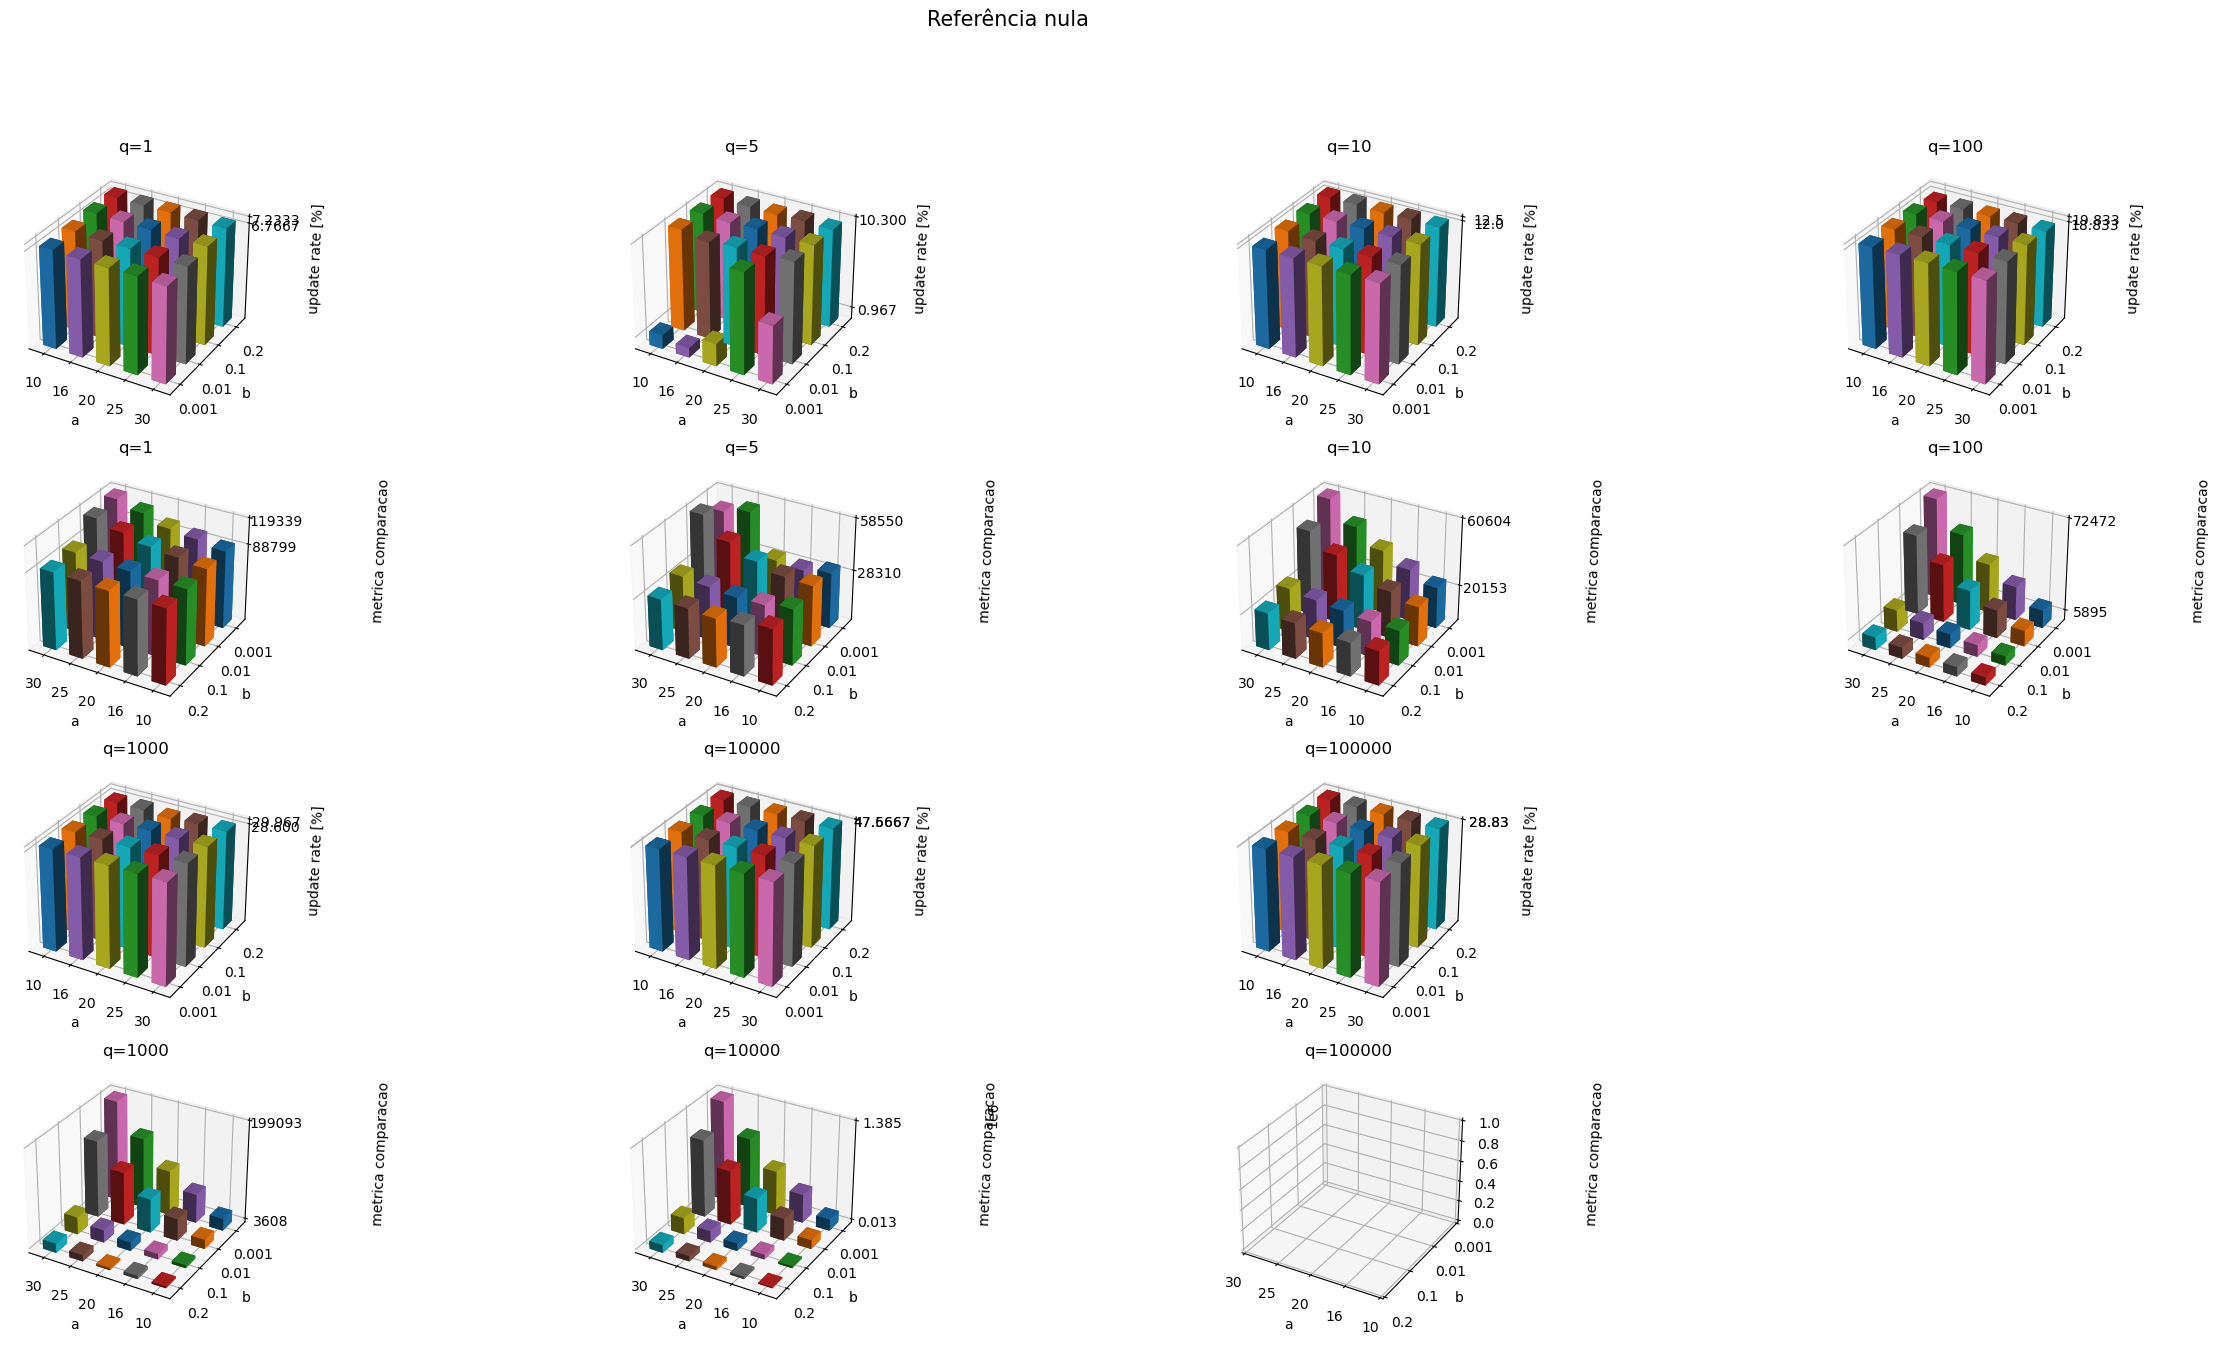

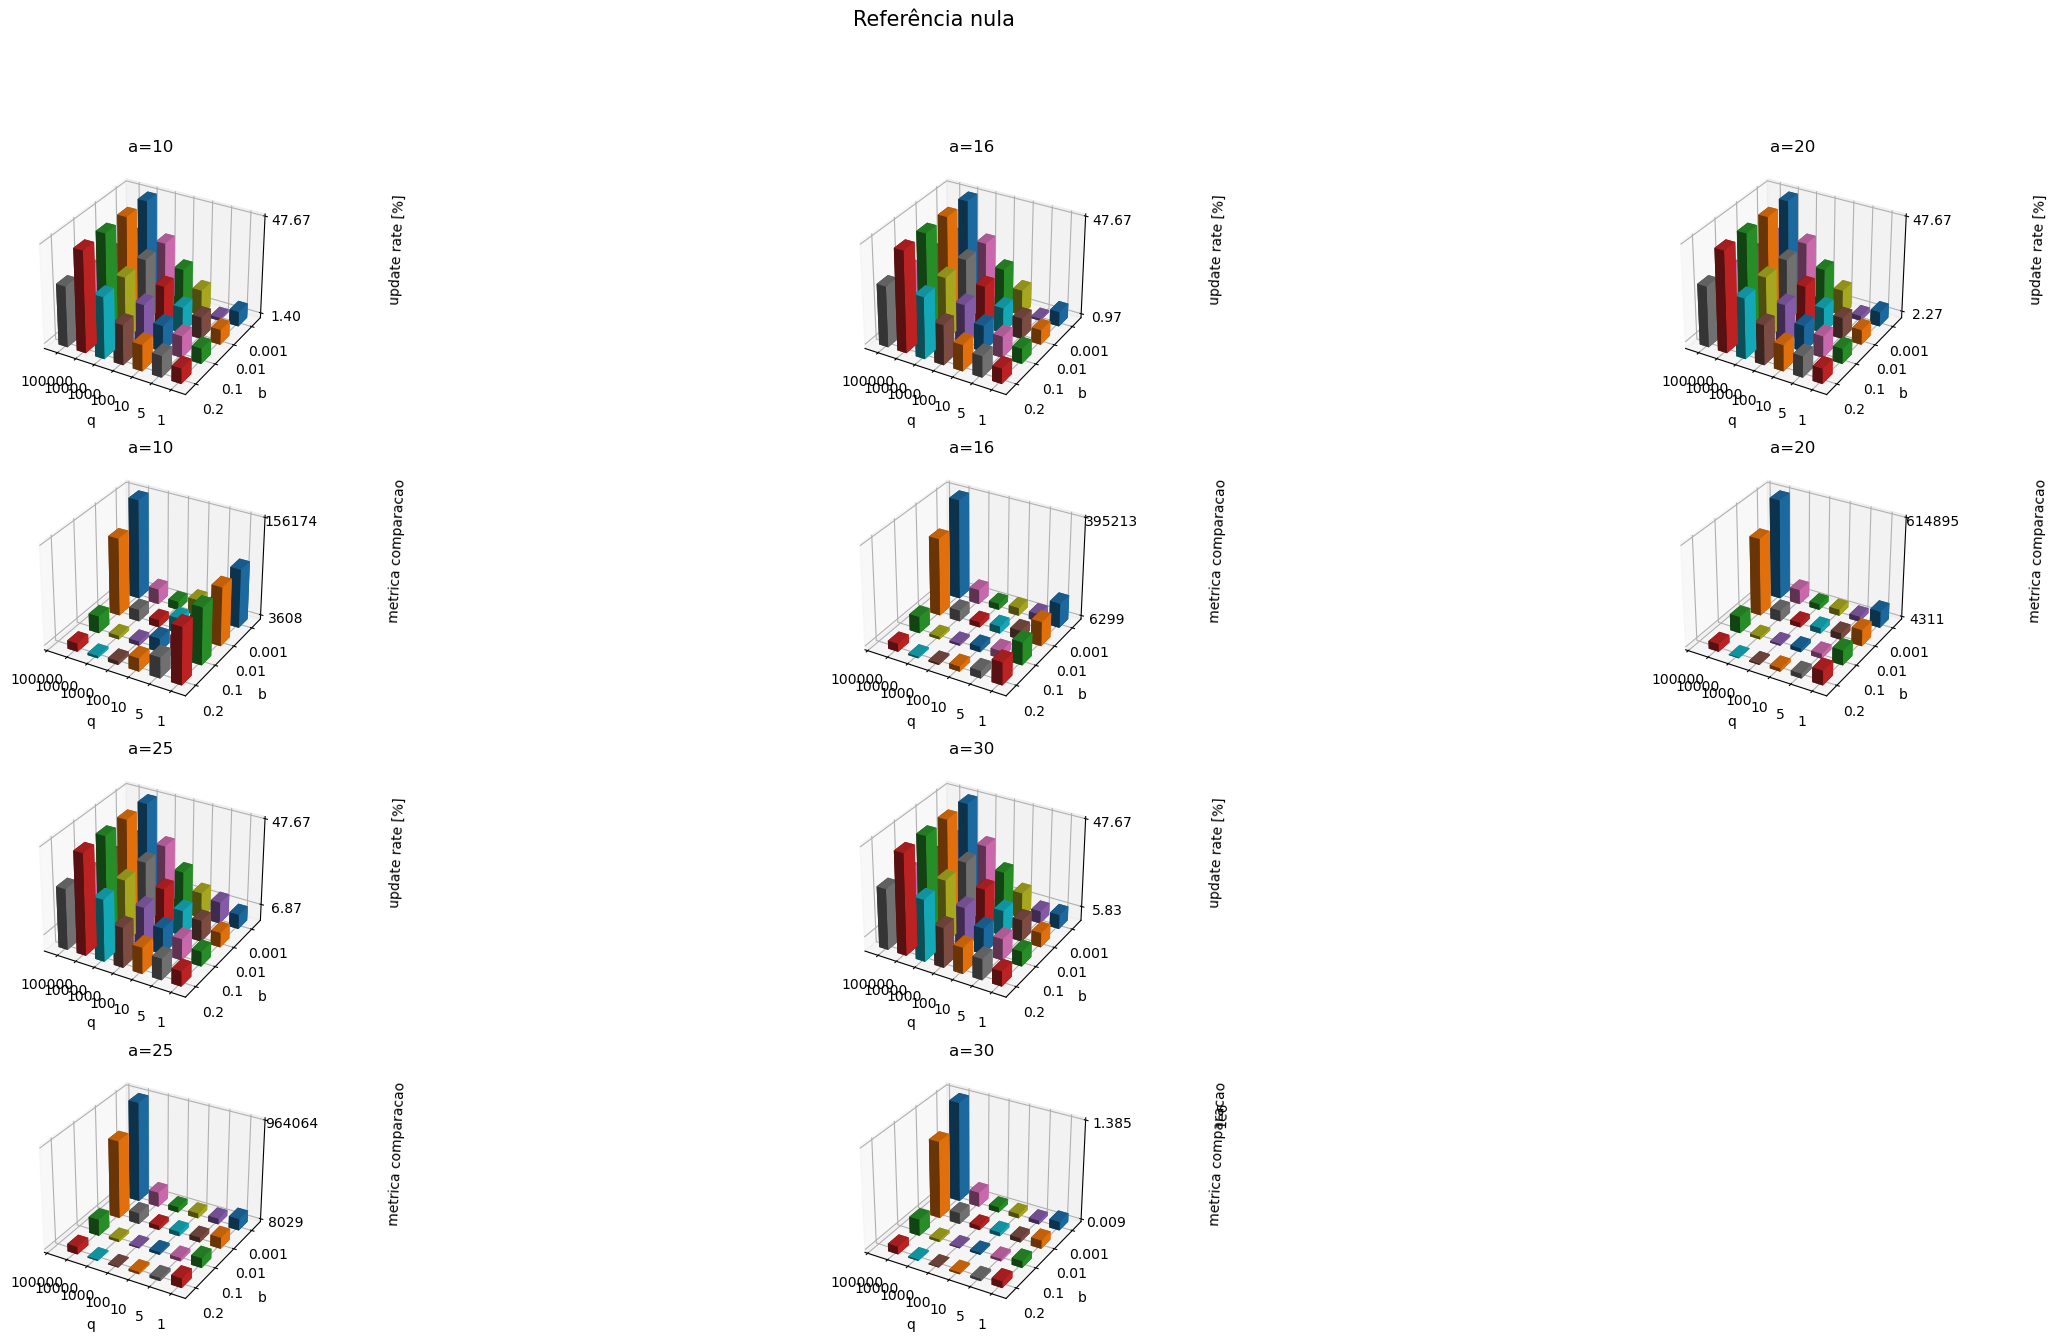

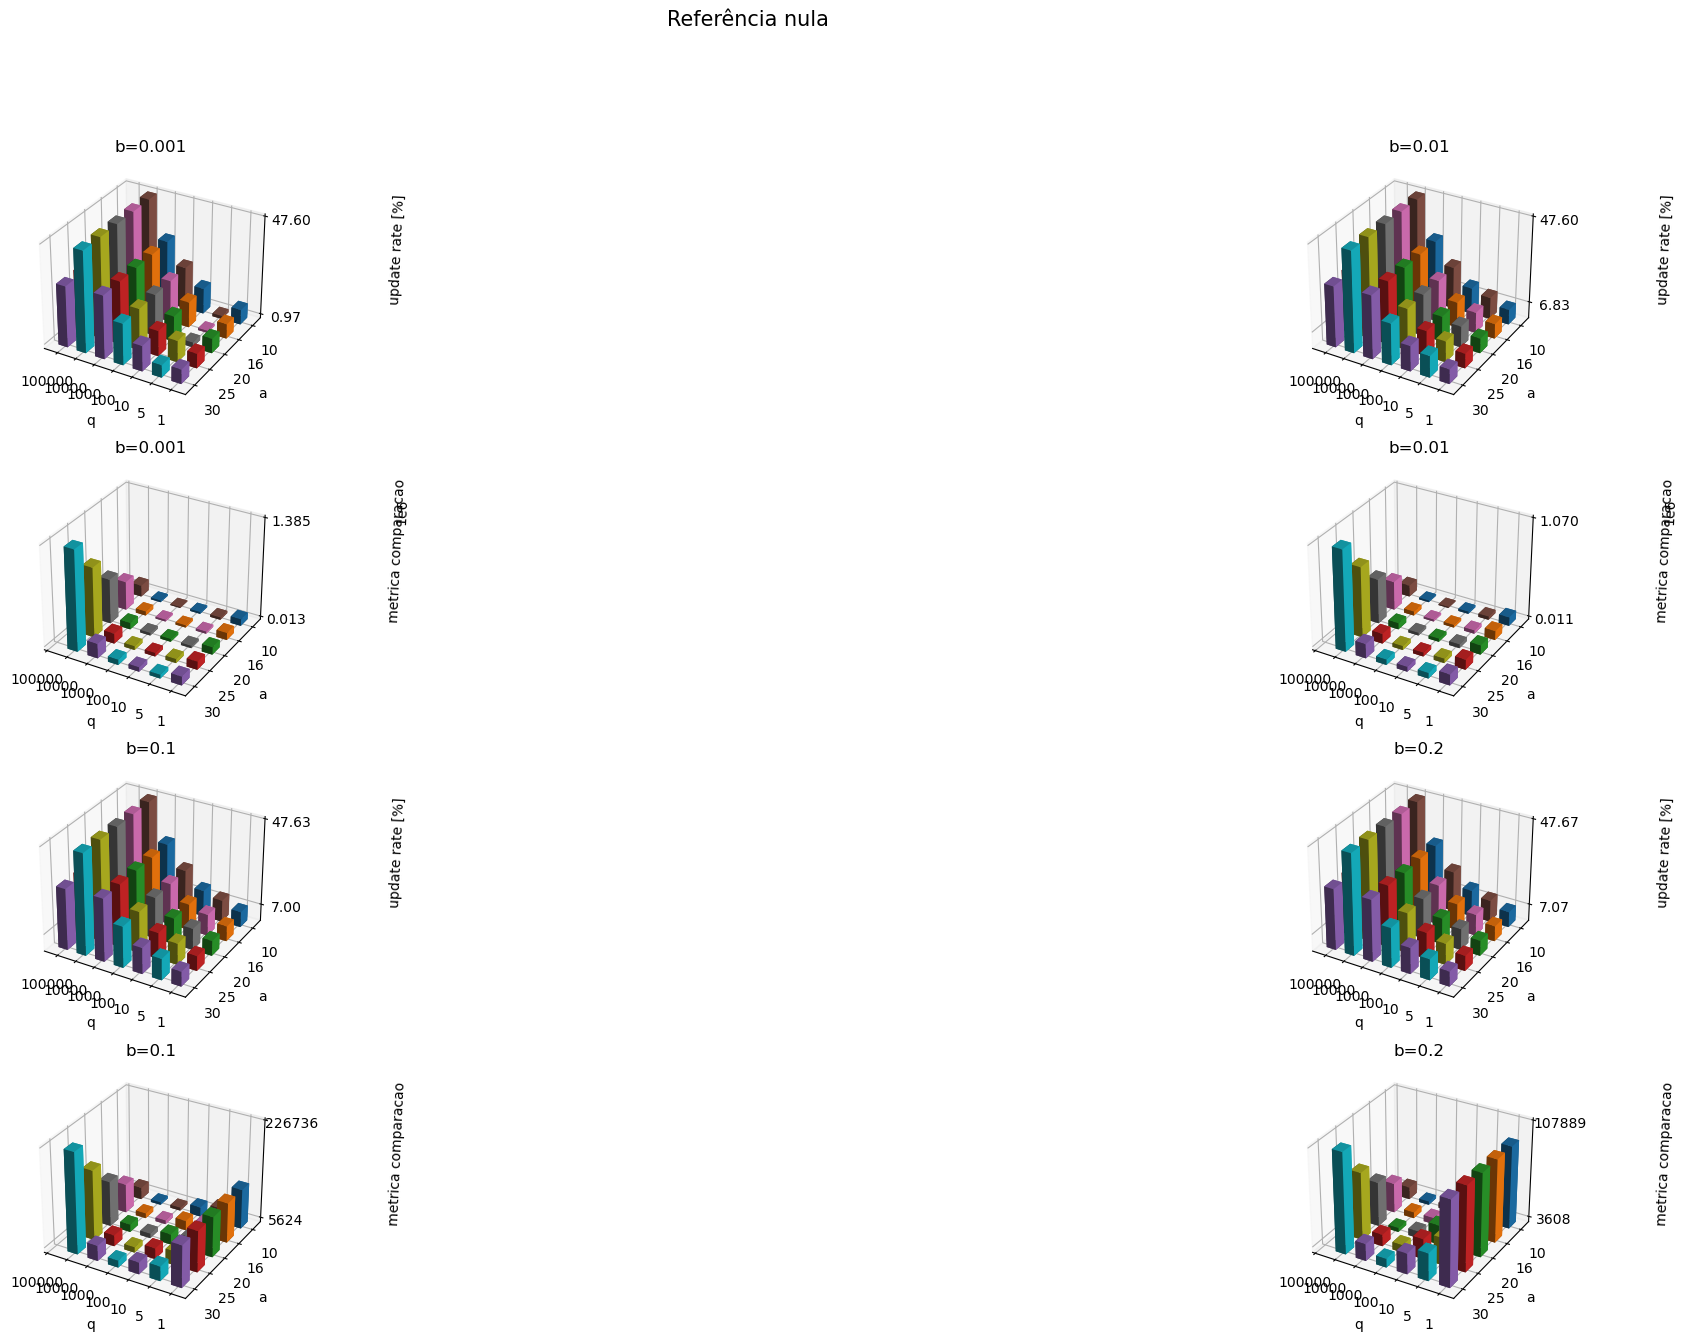

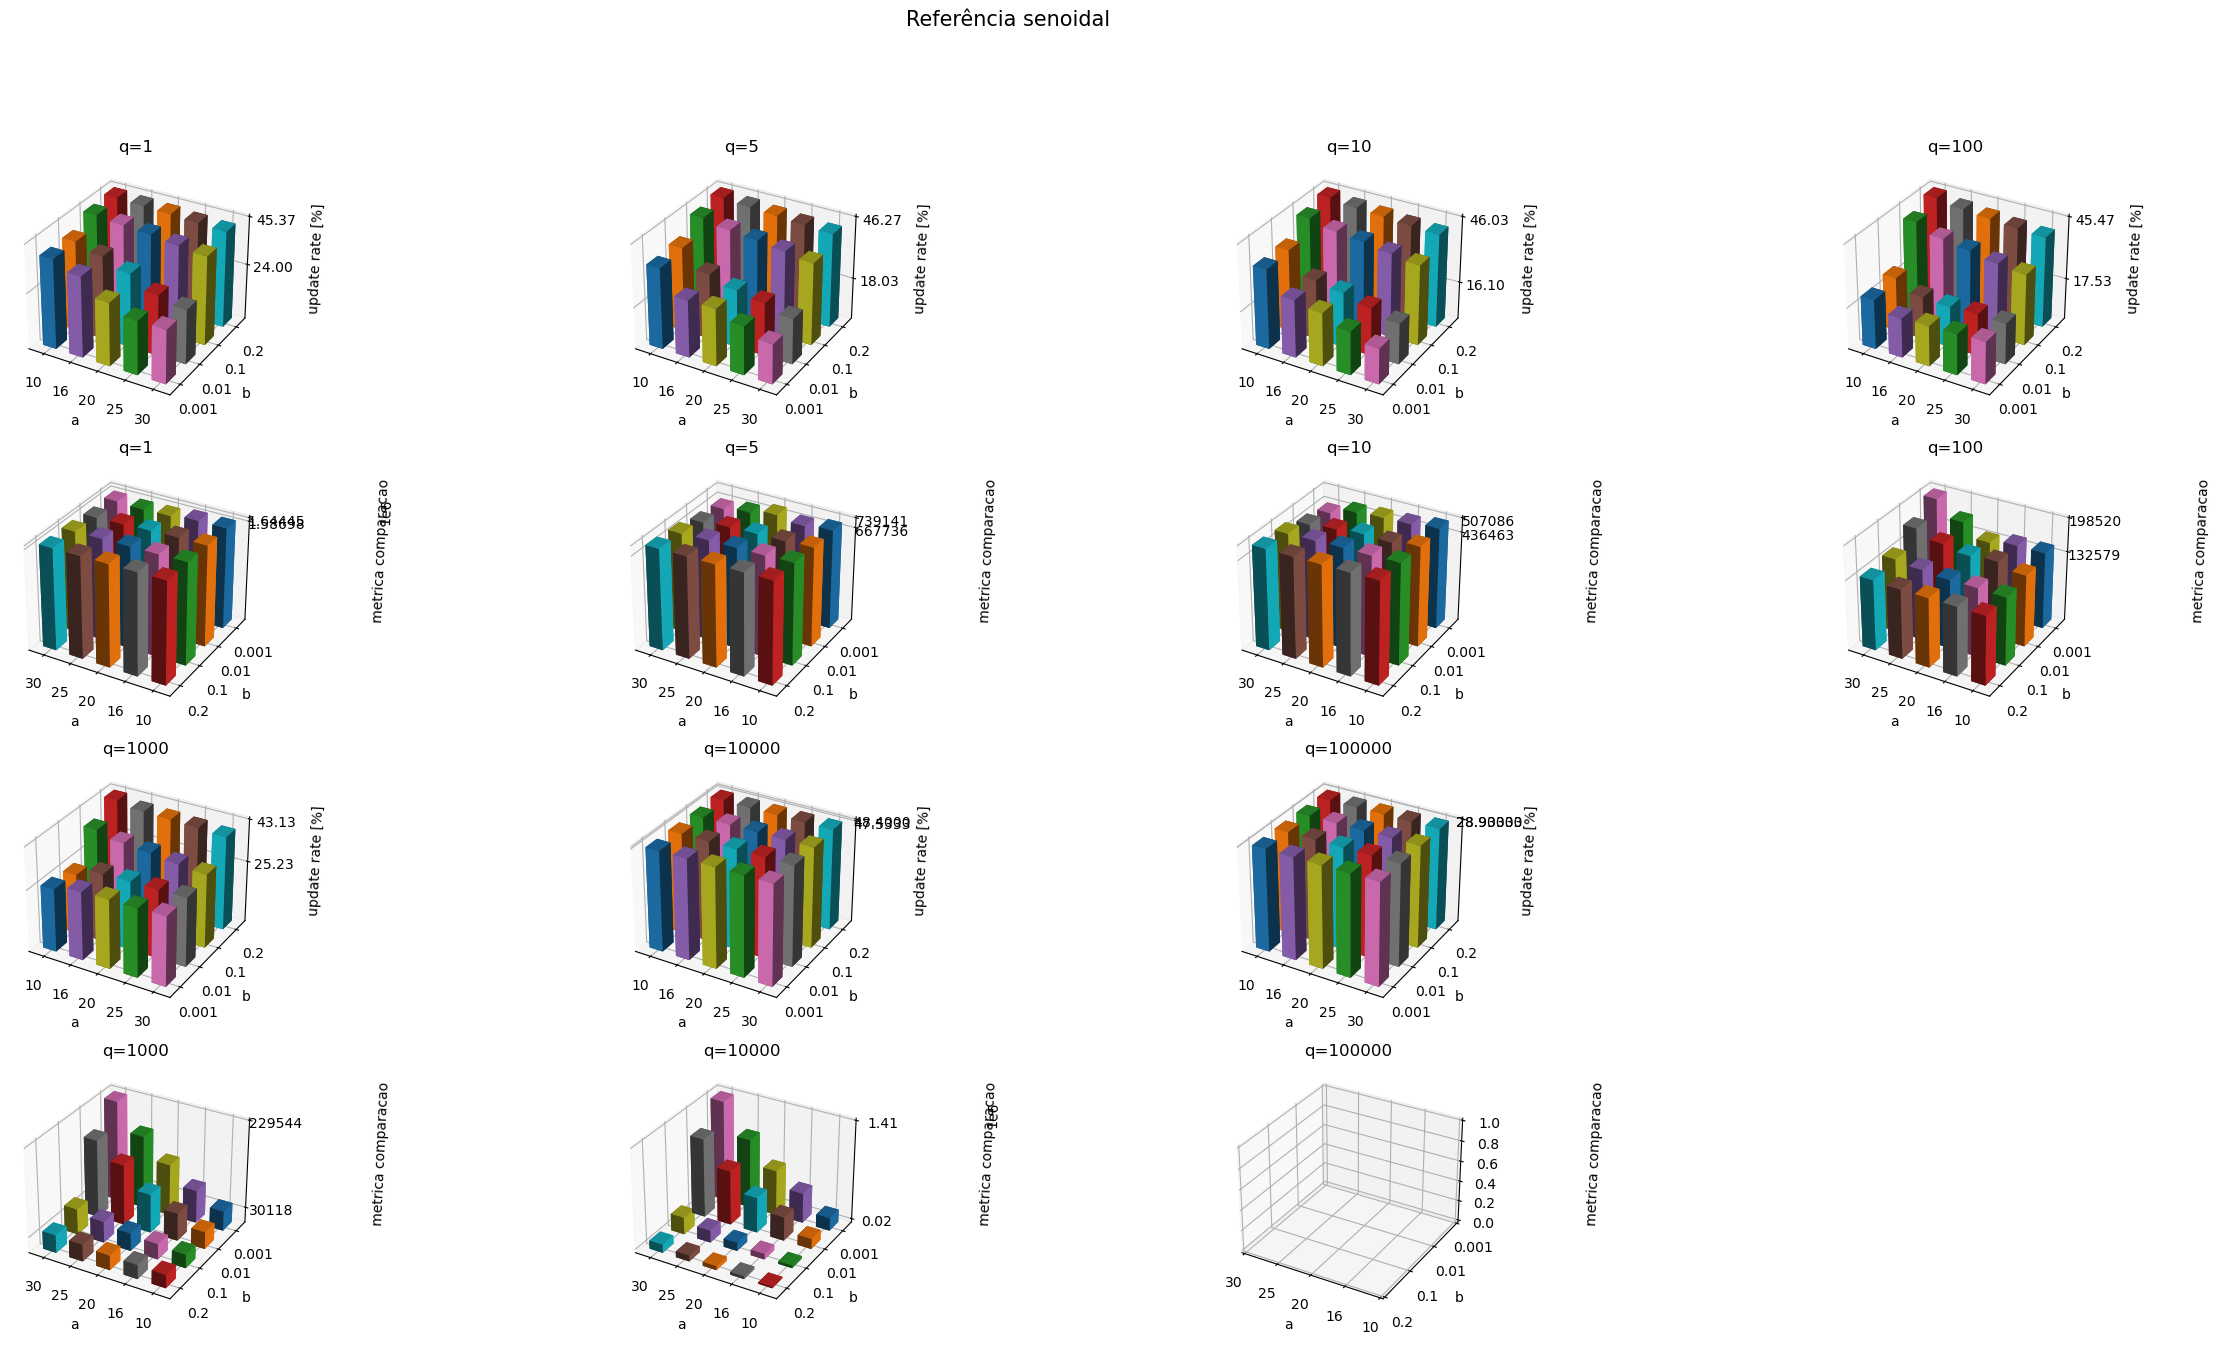

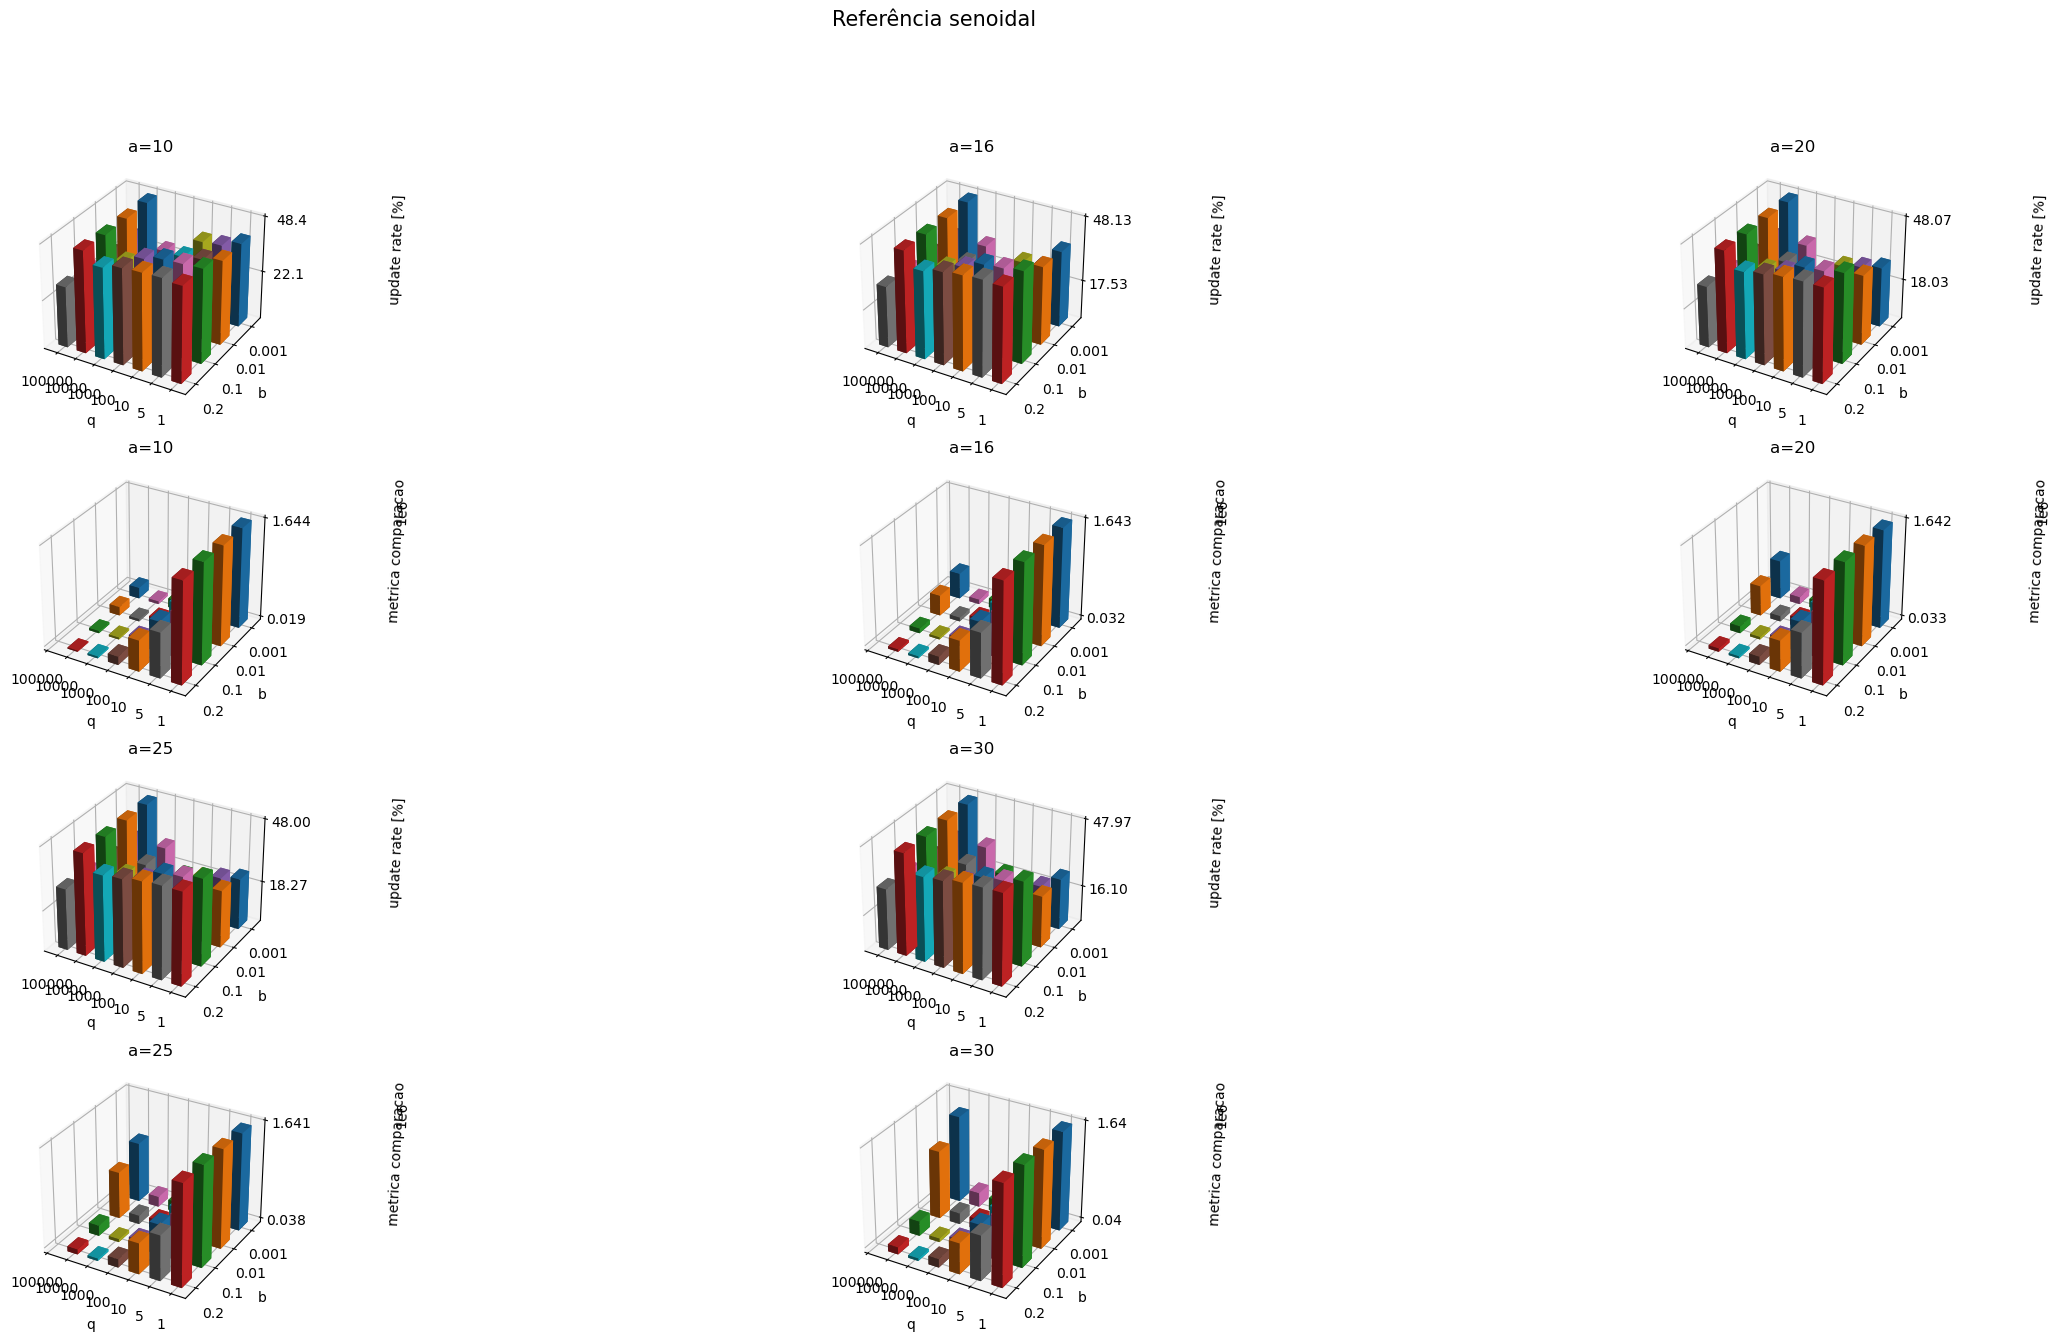

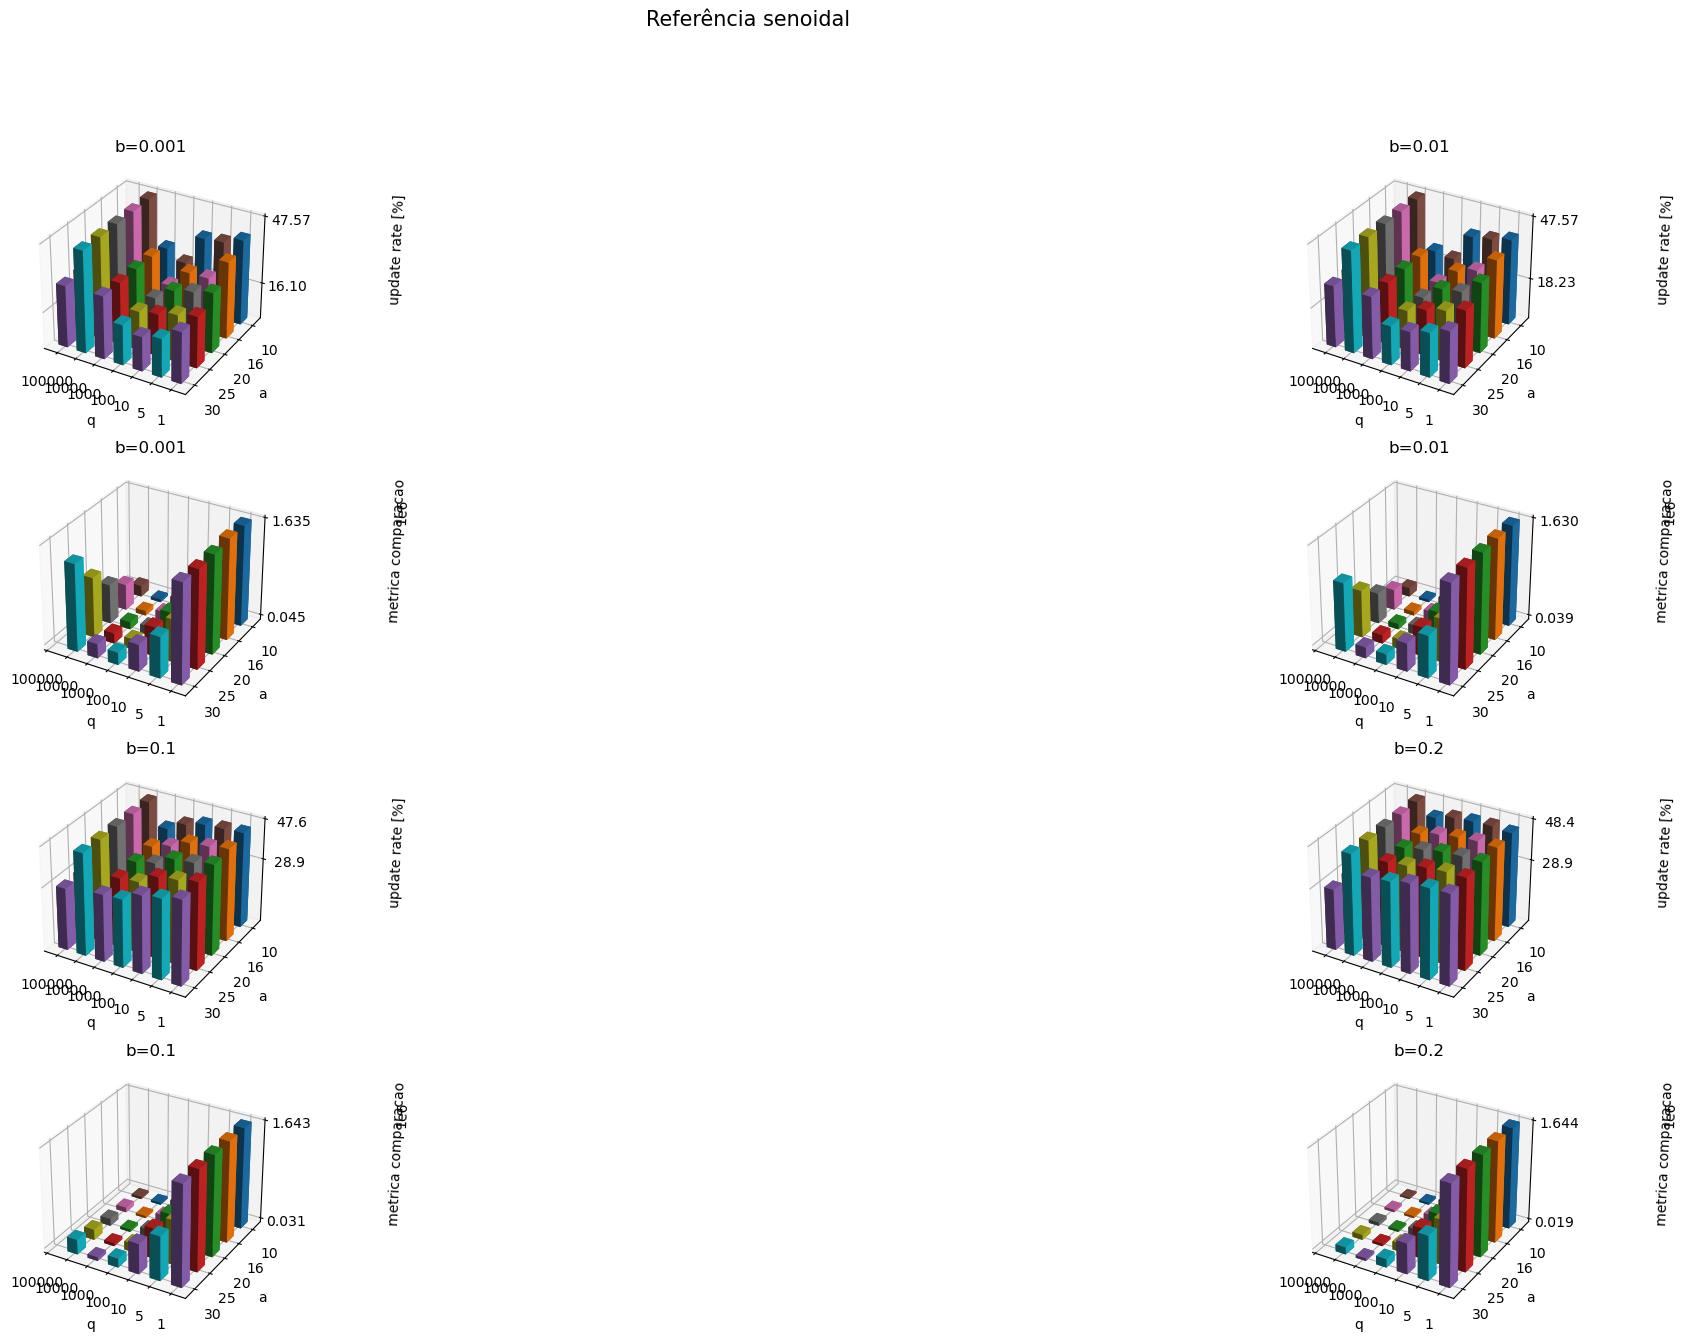

In [63]:
plt.rcParams.update({'font.size': 10})

ct, control_type = ControlType.EventDLQR, "event_dlqr"

metrics = ['update_rate', 'metrica_comparacao']

def indexes2graphname(i, j, num_rows, num_cols, parameter_values, metrics):
    metric_name = metrics[i % 2]
    if i < 2:
        return f"{parameter_values[j]}_{metric_name}"
    else:
        if j+num_cols >= len(parameter_values):
            raise Exception(f"j+num_cols is {j}+{num_cols}={j+num_cols} >= len(parameter_values) = {len(parameter_values)}. Something is WRONG!")
        return f"{parameter_values[j+num_cols]}_{metric_name}"



for pt, problem_type in zip([ProblemType.Regulator, ProblemType.Compensator], ["Referência nula", "Referência senoidal"]):

    abQ = {}

    for k,v in dict_data[ct][pt]['data'].items():
        if not abQ.get(v['a']):
            abQ[v['a']] = {}
        if not abQ[v['a']].get(v['b']):
            abQ[v['a']][v['b']] = {}
        if not abQ[v['a']][v['b']].get(v['Q'][0,0]):
            abQ[v['a']][v['b']][v['Q'][0,0]] = {}
        abQ[v['a']][v['b']][v['Q'][0,0]] = k

    from pprint import pprint

    #pprint(abQ)

    bottom = 0
    width = .5
    depth = .5

    view_elevation=30
    view_azim=120

    graph_top_q = False
    graph_top_q = True

    graph_top_a = False
    graph_top_a = True
    
    graph_top_b = False
    graph_top_b = True

    if graph_top_q:
        print(f"ploting graph_top_q")
        linhas = 4
        colunas = 4
        q = [int(q[0,0]) for q in QQ]
        # set up the figure and axes
        fig, axs = plt.subplots(linhas, colunas, figsize=(30, 15), subplot_kw={'projection':'3d'})
        fig.suptitle(problem_type, size=15)
        ax = {}
        
        for i in range(linhas):
            for j in range(colunas):
                try:
                    ax[indexes2graphname(i, j, linhas, colunas, q, metrics)] = axs[i,j]
                except:
                    print(i, j, "continuing...")
                    axs[i,j].set_axis_off()
                    continue
        
        print(ax.keys())

        for q in [int(q[0,0]) for q in QQ]:
            bars = []
            value_update_rate=[]
            key = f'{q}_update_rate'
            for xa, a in enumerate(aa):
                for yb, b in enumerate(bb):
                    index = abQ[a][b][q]
                    value_update_rate.append(dict_data[ct][pt]['data'][index]['update_rate']*100)
                    #print(f'{a:<5} {b:<5} {q:<5} {value_update_rate[-1]:<10.2f}')
                    bars.append(ax[key].bar3d(xa-width/2, yb-depth/2, bottom, width, depth, value_update_rate[-1], shade=True))
                    #ax[key].view_init(elev=view_elevation, azim=view_azim)
                    
            
            ax[key].set_title(f"q={q}")
            ax[key].set_xlabel(f"a")
            ax[key].set_ylabel(f"b")
            ax[key].set_zlabel(f"update rate [%]", labelpad = 40)
            #original_ticks = ax[key].get_zticks()
            #ax[key].set_zticks((*original_ticks, max(top), min(top)))
            ax[key].set_zticks(( max(value_update_rate), min(value_update_rate)))
            ax[key].zaxis.labelpad = 10
            #ax[key].get_xticklabels()[-1].set_color("red")
            #ax[key].get_xticklabels()[-2].set_color("red")
            ax[key].set_xticks(list(range(len(aa))),aa)
            ax[key].set_yticks(list(range(len(bb))),bb)
            value_update_rate = np.asarray(value_update_rate)
            value_update_rate = value_update_rate/np.max(value_update_rate)
            #for b,t in zip(bars,top):
                #b.set(color=(t,0,0))
    
        for q in [int(q[0,0]) for q in QQ]:
            bars = []
            value_metrica_comparacao=[]
            key = f'{q}_metrica_comparacao'
            for xa, a in enumerate(aa):
                for yb, b in enumerate(bb):
                    index = abQ[a][b][q]
                    value_metrica_comparacao.append(dict_data[ct][pt]['data'][index]['metrica_comparacao'])
                    #print(f'{a:<5} {b:<5} {q:<5} {value_metrica_comparacao[-1]:<10.2f}')
                    if value_metrica_comparacao[-1] == np.inf:
                        value_metrica_comparacao.pop()
                    else:
                        bars.append(ax[key].bar3d(xa-width/2, yb-depth/2, bottom, width, depth, value_metrica_comparacao[-1], shade=True))
            ax[key].set_title(f"q={q}")
            ax[key].set_xlabel(f"a")
            ax[key].set_ylabel(f"b")
            ax[key].set_zlabel(f"metrica comparacao", labelpad = 40)
            ax[key].view_init(elev=view_elevation, azim=view_azim)
            #original_ticks = ax[key].get_zticks()
            #ax[key].set_zticks((*original_ticks, max(top), min(top)))
            if value_metrica_comparacao:
                ax[key].set_zticks(( max(value_metrica_comparacao), min(value_metrica_comparacao)))
            #ax[key].get_xticklabels()[-1].set_color("red")
            #ax[key].get_xticklabels()[-2].set_color("red")
            ax[key].set_xticks(list(range(len(aa))),aa)
            ax[key].set_yticks(list(range(len(bb))),bb)
            #value_metrica_comparacao = np.asarray(value_metrica_comparacao)
            #value_metrica_comparacao = value_metrica_comparacao/np.max(value_metrica_comparacao)
            #for b,t in zip(bars,top):
                #b.set(color=(t,0,0))
    
        
    if graph_top_a:

        print(f"ploting graph_top_a")
        linhas = 4
        colunas = 3
        # set up the figure and axes
        fig, axs = plt.subplots(linhas, colunas, figsize=(30, 15), subplot_kw={'projection':'3d'})
        fig.suptitle(problem_type, size=15)
        ax = {}
        
        for i in range(linhas):
            for j in range(colunas):
                try:
                    ax[indexes2graphname(i, j, linhas, colunas, aa, metrics)] = axs[i,j]
                except:
                    print(i, j, "continuing...")
                    axs[i,j].set_axis_off()
                    continue
        
        print(ax.keys())

        for a in aa:
            bars = []
            value_update_rate=[]
            for xq, q in enumerate([int(q[0,0]) for q in QQ]):
                key = f'{a}_update_rate'
                for yb, b in enumerate(bb):
                    index = abQ[a][b][q]
                    value_update_rate.append(dict_data[ct][pt]['data'][index]['update_rate']*100)
                    #print(f'{a:<5} {b:<5} {q:<5} {value_update_rate[-1]:<10.2f}')
                    bars.append(ax[key].bar3d(xq-width/2, yb-depth/2, bottom, width, depth, value_update_rate[-1], shade=True))
            ax[key].set_title(f"a={a}")
            ax[key].set_xlabel(f"q")
            ax[key].set_ylabel(f"b")
            ax[key].set_zlabel(f"update rate [%]", labelpad = 40)
            ax[key].view_init(elev=view_elevation, azim=view_azim)            
            #original_ticks = ax[key].get_zticks()
            #ax[key].set_zticks((*original_ticks, max(top), min(top)))
            ax[key].set_zticks(( max(value_update_rate), min(value_update_rate)))
            #ax[key].get_xticklabels()[-1].set_color("red")
            #ax[key].get_xticklabels()[-2].set_color("red")
            ax[key].set_xticks(list(range(len(QQ))),[int(q[0,0]) for q in QQ])
            ax[key].set_yticks(list(range(len(bb))),bb)
            value_update_rate = np.asarray(value_update_rate)
            value_update_rate = value_update_rate/np.max(value_update_rate)
            #for b,t in zip(bars,top):
                #b.set(color=(t,0,0))
            
        for a in aa:
            bars = []
            value_metrica_comparacao=[]
            for xq, q in enumerate([int(q[0,0]) for q in QQ]):
                key = f'{a}_metrica_comparacao'
                for yb, b in enumerate(bb):
                    index = abQ[a][b][q]
                    value_metrica_comparacao.append(dict_data[ct][pt]['data'][index]['metrica_comparacao'])
                    #print(f'{a:<5} {b:<5} {q:<5} {value_metrica_comparacao[-1]:<10.2f}')
                    if value_metrica_comparacao[-1] == np.inf:
                        value_metrica_comparacao.pop()
                    else:
                        bars.append(ax[key].bar3d(xq-width/2, yb-depth/2, bottom, width, depth, value_metrica_comparacao[-1], shade=True))
            ax[key].set_title(f"a={a}")
            ax[key].set_xlabel(f"q")
            ax[key].set_ylabel(f"b")
            ax[key].set_zlabel(f"metrica comparacao", labelpad = 40)
            ax[key].view_init(elev=view_elevation, azim=view_azim)
            #original_ticks = ax[key].get_zticks()
            #ax[key].set_zticks((*original_ticks, max(top), min(top)))
            if value_metrica_comparacao:
                ax[key].set_zticks(( max(value_metrica_comparacao), min(value_metrica_comparacao)))
            #ax[key].get_xticklabels()[-1].set_color("red")
            #ax[key].get_xticklabels()[-2].set_color("red")
            ax[key].set_xticks(list(range(len(QQ))),[int(q[0,0]) for q in QQ])
            ax[key].set_yticks(list(range(len(bb))),bb)
            #value_metrica_comparacao = np.asarray(value_metrica_comparacao)
            #value_metrica_comparacao = value_metrica_comparacao/np.max(value_metrica_comparacao)
            #for b,t in zip(bars,top):
                #b.set(color=(t,0,0))
            
    
        
    if graph_top_b:

        print(f"ploting graph_top_b")
        linhas = 4
        colunas = 2
        # set up the figure and axes
        fig, axs = plt.subplots(linhas, colunas, figsize=(30, 15), subplot_kw={'projection':'3d'})
        fig.suptitle(problem_type, size=15)
        ax = {}
        
        for i in range(linhas):
            for j in range(colunas):
                try:
                    ax[indexes2graphname(i, j, linhas, colunas, bb, metrics)] = axs[i,j]
                except:
                    print(i, j, "continuing...")
                    axs[i,j].set_axis_off()
                    continue
        
        print(ax.keys())

        for b in bb:
            bars = []
            value_update_rate=[]
            for xq, q in enumerate([int(q[0,0]) for q in QQ]):
                key = f'{b}_update_rate'
                for ya, a in enumerate(aa):
                    index = abQ[a][b][q]
                    value_update_rate.append(dict_data[ct][pt]['data'][index]['update_rate']*100)
                    #print(f'{a:<5} {b:<5} {q:<5} {value_update_rate[-1]:<10.2f}')
                    bars.append(ax[key].bar3d(xq-width/2, ya-depth/2, bottom, width, depth, value_update_rate[-1], shade=True))
            ax[key].set_title(f"b={b}")
            ax[key].set_xlabel(f"q")
            ax[key].set_ylabel(f"a")
            ax[key].set_zlabel(f"update rate [%]", labelpad = 40)
            ax[key].view_init(elev=view_elevation, azim=view_azim)
            #original_ticks = ax[key].get_zticks()
            #ax[key].set_zticks((*original_ticks, max(top), min(top)))
            ax[key].set_zticks(( max(value_update_rate), min(value_update_rate)))
            #ax[key].get_xticklabels()[-1].set_color("red")
            #ax[key].get_xticklabels()[-2].set_color("red")
            ax[key].set_xticks(list(range(len(QQ))),[int(q[0,0]) for q in QQ])
            ax[key].set_yticks(list(range(len(aa))),aa)
            value_update_rate = np.asarray(value_update_rate)
            value_update_rate = value_update_rate/np.max(value_update_rate)
            #for b,t in zip(bars,top):
                #b.set(color=(t,0,0))
            
        for b in bb:
            bars = []
            value_metrica_comparacao=[]
            for xq, q in enumerate([int(q[0,0]) for q in QQ]):
                key = f'{b}_metrica_comparacao'
                for ya, a in enumerate(aa):
                    index = abQ[a][b][q]
                    value_metrica_comparacao.append(dict_data[ct][pt]['data'][index]['metrica_comparacao'])
                    print(f'{a:<5} {b:<5} {q:<5} {value_metrica_comparacao[-1]:<10.2f}')
                    if value_metrica_comparacao[-1] == np.inf:
                        value_metrica_comparacao.pop()
                    else:
                        bars.append(ax[key].bar3d(xq-width/2, ya-depth/2, bottom, width, depth, value_metrica_comparacao[-1], shade=True))
            ax[key].set_title(f"b={b}")
            ax[key].set_xlabel(f"q")
            ax[key].set_ylabel(f"a")
            ax[key].set_zlabel(f"metrica comparacao", labelpad = 40)
            ax[key].view_init(elev=view_elevation, azim=view_azim)
            #original_ticks = ax[key].get_zticks()
            #ax[key].set_zticks((*original_ticks, max(top), min(top)))
            if value_metrica_comparacao:
                ax[key].set_zticks(( max(value_metrica_comparacao), min(value_metrica_comparacao)))
            #ax[key].get_xticklabels()[-1].set_color("red")
            #ax[key].get_xticklabels()[-2].set_color("red")
            ax[key].set_xticks(list(range(len(QQ))),[int(q[0,0]) for q in QQ])
            ax[key].set_yticks(list(range(len(aa))),aa)
            #value_metrica_comparacao = np.asarray(value_metrica_comparacao)
            #value_metrica_comparacao = value_metrica_comparacao/np.max(value_metrica_comparacao)
            #for b,t in zip(bars,top):
                #b.set(color=(t,0,0))


In [64]:
for ct, control_type in zip([ControlType.DLQR, ControlType.EventDLQR], ["dlqr", "event_dlqr"]):
    for pt, problem_type in zip([ProblemType.Regulator, ProblemType.Compensator], ["regulator", "compensator"]):
        print()
        print("----------------------------------------------")
        print(f"[{problem_type}] MENOR UPDATE RATE")
        idx = dict_data[ct][pt]['menor_update_rate']
        print("A = \n", dict_data['sys_A']) # expected A = [[ 9.98609061e-01, 1.09025360e+01], [-1.13123668e-04, 9.77691957e-01]]
        print("B = \n", dict_data['sys_B']) # expected B = [[0.0086104 ], [0.00080799]]
        print("K = \n", dict_data[ct][pt]['data'][idx]['K']) # expected K = [[  -1.90977601, -194.49064542]]
        print("a = ", dict_data[ct][pt]['data'][idx]['a']) # expected a = 16
        print("b = ", dict_data[ct][pt]['data'][idx]['b']) # expected b = .001
        print("q = ", dict_data[ct][pt]['data'][idx]['Q'][0,0]) # expected Q = 5 -> [[5,0],[0,1]]
        print(f"update_rate = {dict_data[ct][pt]['data'][idx]['update_rate']*100:.3f} %") # expected 0.00967 * 100 = 0.967 %
        print(f"metrica_comparacao = {dict_data[ct][pt]['data'][idx]['metrica_comparacao']}") # expected: 29666.601804295286
        print()
        print(f"[{problem_type}] MENOR METRICA COMPARACAO")
        idx = dict_data[ct][pt]['menor_metrica_comparacao']
        print('A = \n', dict_data['sys_A']) # expected A = [[ 9.98609061e-01, 1.09025360e+01], [-1.13123668e-04, 9.77691957e-01]]
        print('B = \n', dict_data['sys_B']) # expected B = [[0.0086104 ], [0.00080799]]
        print('K = \n', dict_data[ct][pt]['data'][idx]['K']) # expected K = [[ -21.67640067, -644.0524653 ]]
        print('a = ', dict_data[ct][pt]['data'][idx]['a']) # expected a = 10
        print('b = ', dict_data[ct][pt]['data'][idx]['b']) # expected b = .2
        print('q = ', dict_data[ct][pt]['data'][idx]['Q'][0,0]) # expected q = 1000 -> [[1000,0],[0,1]]
        print(f"update_rate = {dict_data[ct][pt]['data'][idx]['update_rate']*100} %") # expected 0.29166666666666668 * 100 = 29.166666666666668 %
        print(f"metrica_comparacao = {dict_data[ct][pt]['data'][idx]['metrica_comparacao']}") # expected: 3607.518616720655


----------------------------------------------
[regulator] MENOR UPDATE RATE
A = 
 [[ 9.98609061e-01  1.09025360e+01]
 [-1.13123668e-04  9.77691957e-01]]
B = 
 [[0.0086104 ]
 [0.00080799]]
K = 
 [[  -0.81558916 -121.23101168]]
a =  0
b =  0
q =  1
update_rate = 100.000 %
metrica_comparacao = 67547.6226387733

[regulator] MENOR METRICA COMPARACAO
A = 
 [[ 9.98609061e-01  1.09025360e+01]
 [-1.13123668e-04  9.77691957e-01]]
B = 
 [[0.0086104 ]
 [0.00080799]]
K = 
 [[  -89.91776447 -1155.41172613]]
a =  0
b =  0
q =  100000.0
update_rate = 100.0 %
metrica_comparacao = 0.7262437697289774

----------------------------------------------
[compensator] MENOR UPDATE RATE
A = 
 [[ 9.98609061e-01  1.09025360e+01]
 [-1.13123668e-04  9.77691957e-01]]
B = 
 [[0.0086104 ]
 [0.00080799]]
K = 
 [[  -0.81558916 -121.23101168]]
a =  0
b =  0
q =  1
update_rate = 100.000 %
metrica_comparacao = 1651809.0659470193

[compensator] MENOR METRICA COMPARACAO
A = 
 [[ 9.98609061e-01  1.09025360e+01]
 [-1.13123668

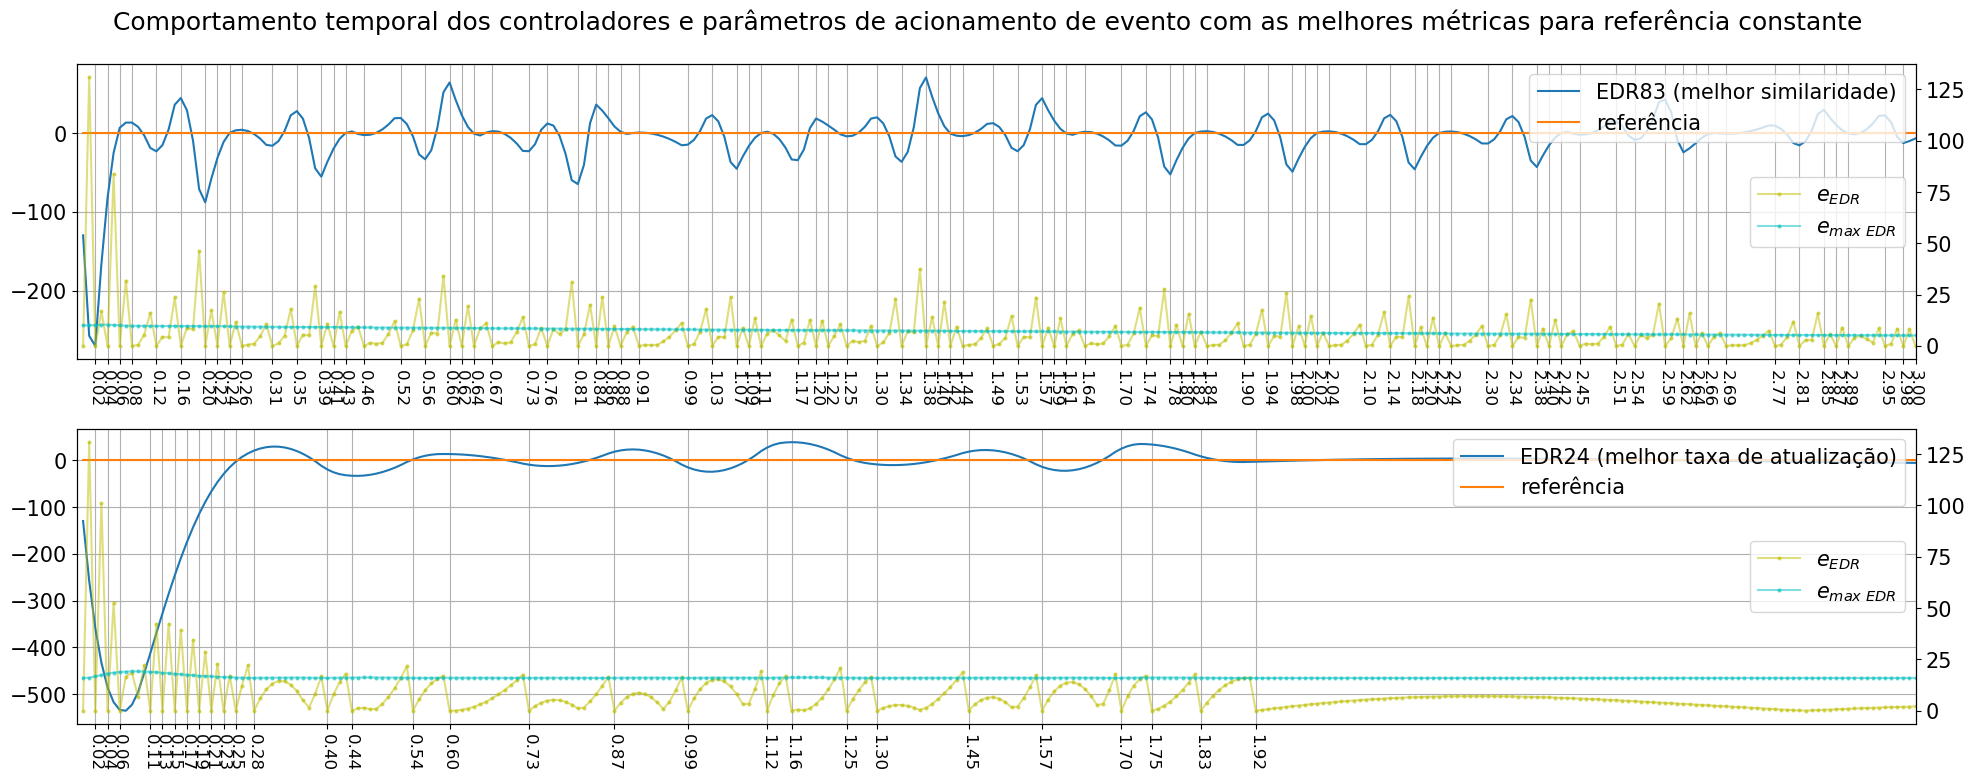

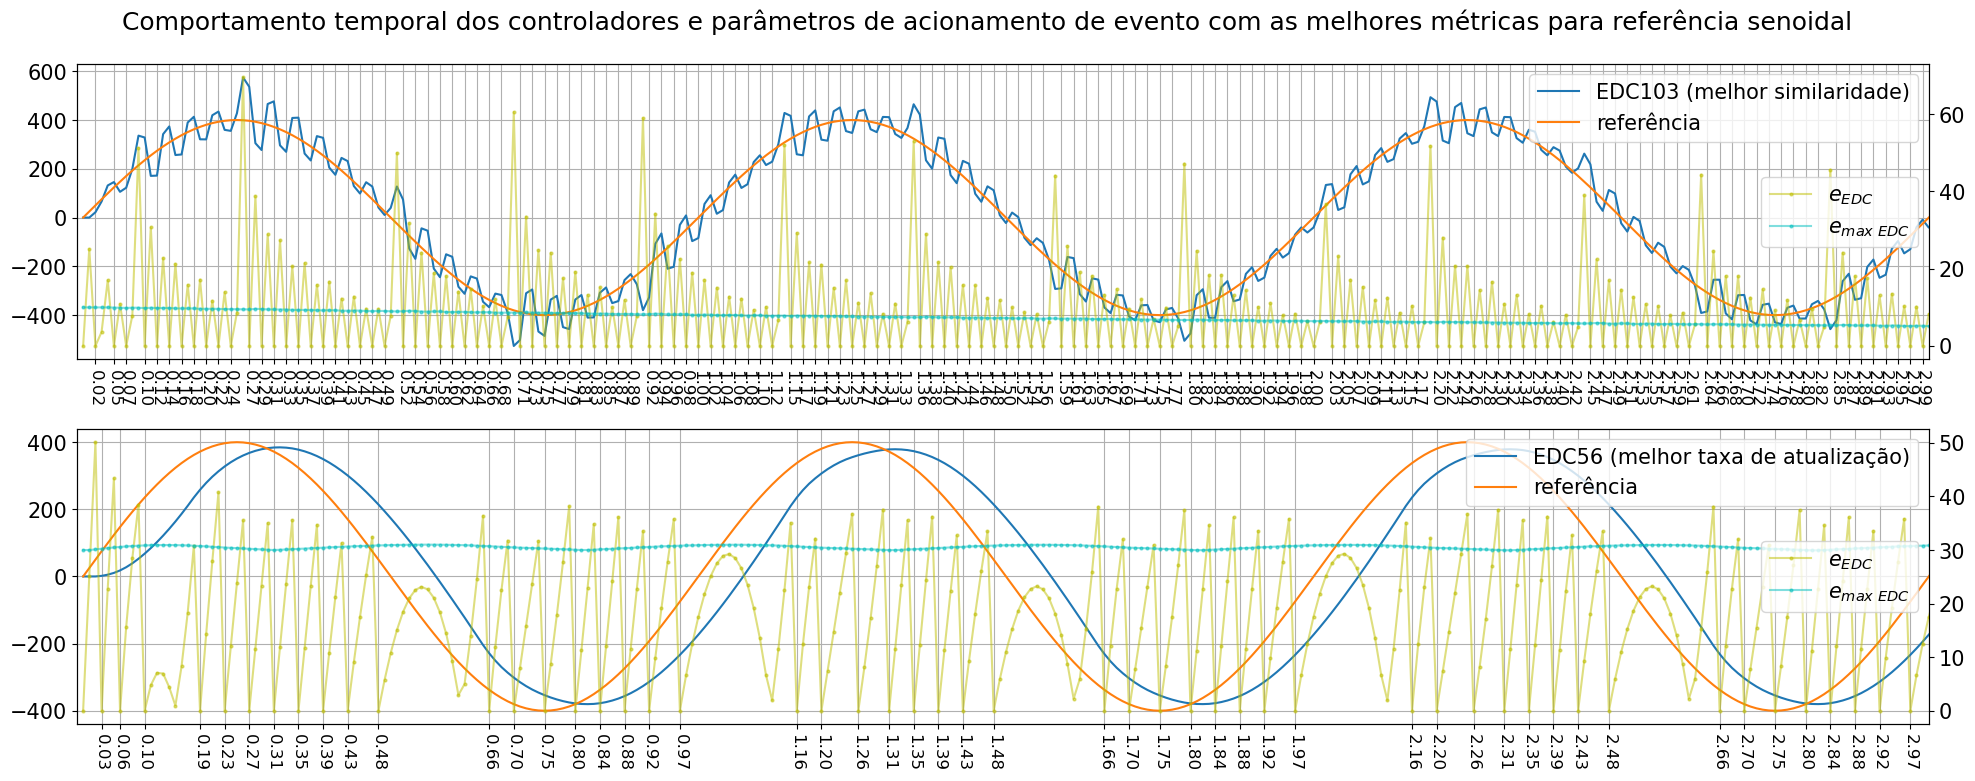

In [65]:
plt.rcParams.update({'font.size': 15})
xlim = [-.01, 3]
ct, control_type = ControlType.EventDLQR, "event_dlqr"
for pt, problem_type in zip([ProblemType.Regulator, ProblemType.Compensator], ["regulator", "compensator"]):

    fig, ax = plt.subplots(2, 1, figsize=(20,8))
    plt.suptitle(f"Comportamento temporal dos controladores e parâmetros de acionamento de evento com as melhores métricas para referência {'constante' if pt == ProblemType.Regulator else 'senoidal'}")

    idx = dict_data[ct][pt]['menor_metrica_comparacao']
    data = dict_data[ct][pt]['data'][idx]
    ax[0].plot(T, data['X'][0])
    ax[0].plot(T, data['Xref'][0])
    ax[0].legend([f'EDR{idx} (melhor similaridade)' if pt == ProblemType.Regulator else f'EDC{idx} (melhor similaridade)', 'referência'], loc="upper right")
    ax[0].set_xticks(data['event_xticks'], ha='right', label=[])
    ax[0].tick_params(axis='x', labelrotation=-90, labelsize=12)
    ax[0].set_xlim(xlim)
    ax[0].grid()
    
    ax2 = ax[0].twinx()
    ax2.plot(T, data['EV'], 'y-o', markersize=2, alpha=.5)
    ax2.plot(T, data['EEV'], 'c-o', markersize=2, alpha=.5)
    ax2.legend(['$e_{EDR}$', '$e_{max~EDR}$'] if pt == ProblemType.Regulator else ['$e_{EDC}$', '$e_{max~EDC}$'], loc="center right")
    
    idx = dict_data[ct][pt]['menor_update_rate']
    data = dict_data[ct][pt]['data'][idx]
    ax[1].plot(T, data['X'][0])
    ax[1].plot(T, data['Xref'][0])
    ax[1].legend([f'EDR{idx} (melhor taxa de atualização)' if pt == ProblemType.Regulator else f'EDC{idx} (melhor taxa de atualização)', 'referência'], loc="upper right")
    ax[1].set_xticks(data['event_xticks'], ha='right', label=[])
    ax[1].tick_params(axis='x', labelrotation=-90, labelsize=12)
    ax[1].set_xlim(xlim)
    ax[1].grid()
    
    ax2 = ax[1].twinx()
    ax2.plot(T, data['EV'], 'y-o', markersize=2, alpha=.5)
    ax2.plot(T, data['EEV'], 'c-o', markersize=2, alpha=.5)
    ax2.legend(['$e_{EDR}$', '$e_{max~EDR}$'] if pt == ProblemType.Regulator else ['$e_{EDC}$', '$e_{max~EDC}$'], loc="center right")
    fig.tight_layout() 
plt.show()